## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Load a model

In [5]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames# +hodnames

# Specify model configuration
nbody = 'abacuslike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

In [6]:
# Specify data dtype
tracer = 'galaxy'
summaries = ['zPk0', 'zPk2', 'zPk4', 'zQk0']
summary = '+'.join(summaries)
kmax = 0.4
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
os.listdir(modelpath)

['x_val.npy',
 'posterior.pkl',
 'true_logprobs.npy',
 'ids_test.npy',
 'theta_train.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'nets',
 'plot_true_logprobs.jpg',
 'ids_train.npy',
 'theta_val.npy',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'x_train.npy',
 'plot_TARP.jpg',
 'plot_predictions.jpg',
 'ids_val.npy',
 'posterior_samples.npy']

In [7]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

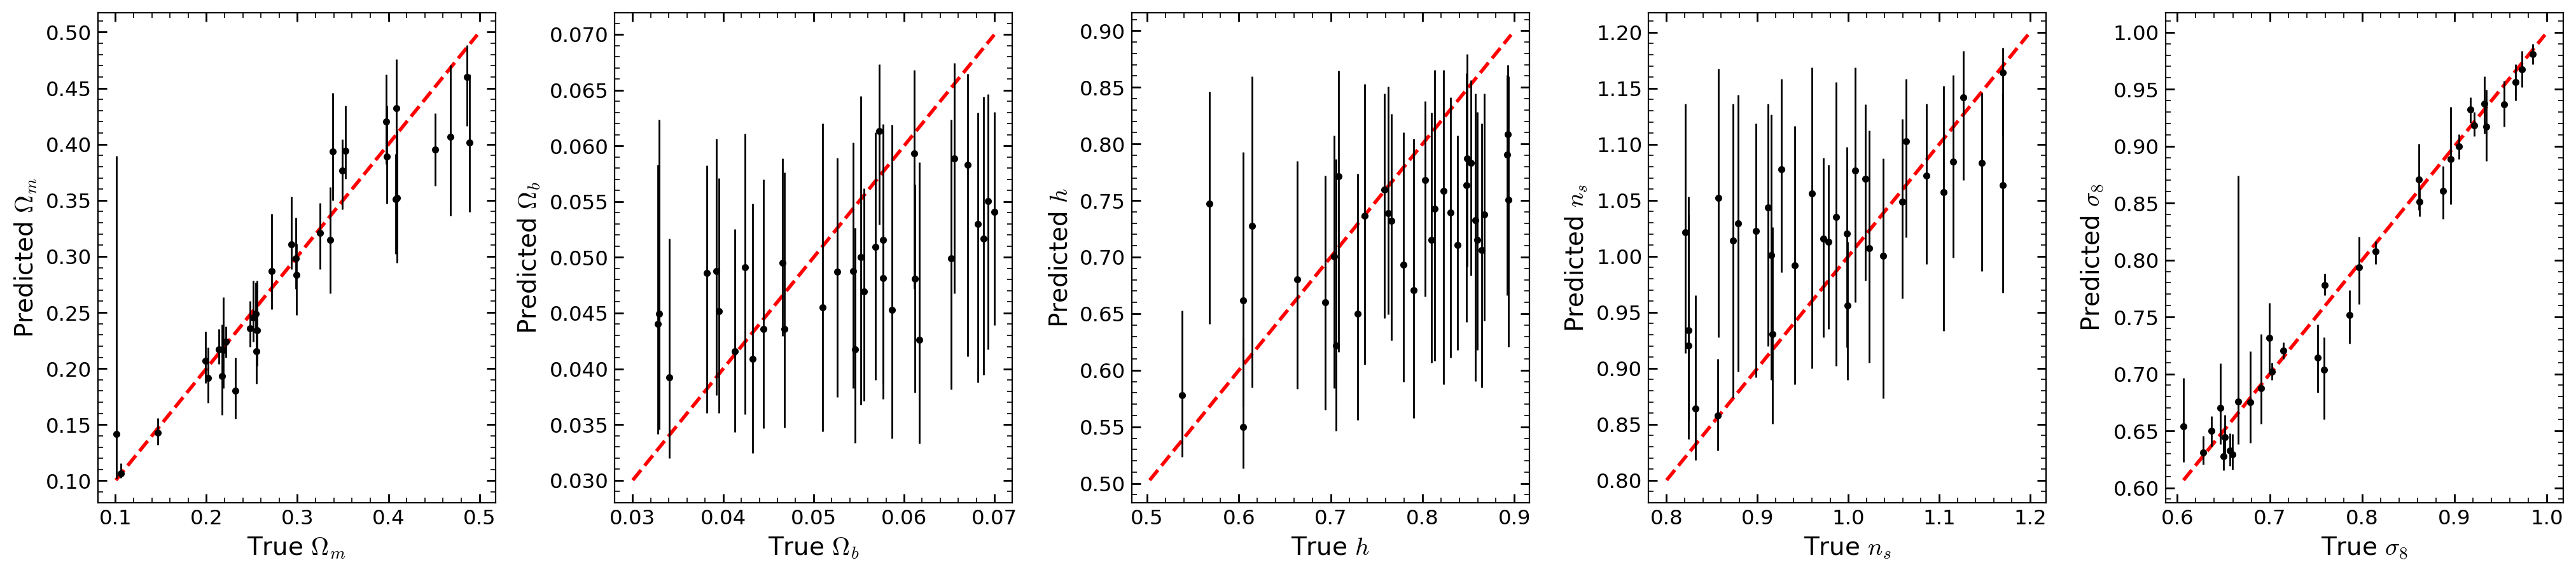

In [9]:

ss = 30

N = len(names)
H, W = N//5, 5
f, axs = plt.subplots(H, W, figsize=(5*W, 5*H), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i >= N:
        ax.axis('off')
        continue
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [7]:
# these functions load pickled torch modules
# if the model was trained on GPU, this will ensure safe loading to CPU
# TODO: update ltu-ili so this is already handled...

import torch
import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def load_posterior(modeldir):
    with open(join(modeldir, 'posterior.pkl'), 'rb') as f:
        ensemble = CPU_Unpickler(f).load()
    ensemble = ensemble.to(device)
    for p in ensemble.posteriors:
        p.to(device)
    return ensemble


posterior = load_posterior(modelpath)

100%|██████████| 10/10 [00:00<00:00, 444.24it/s]


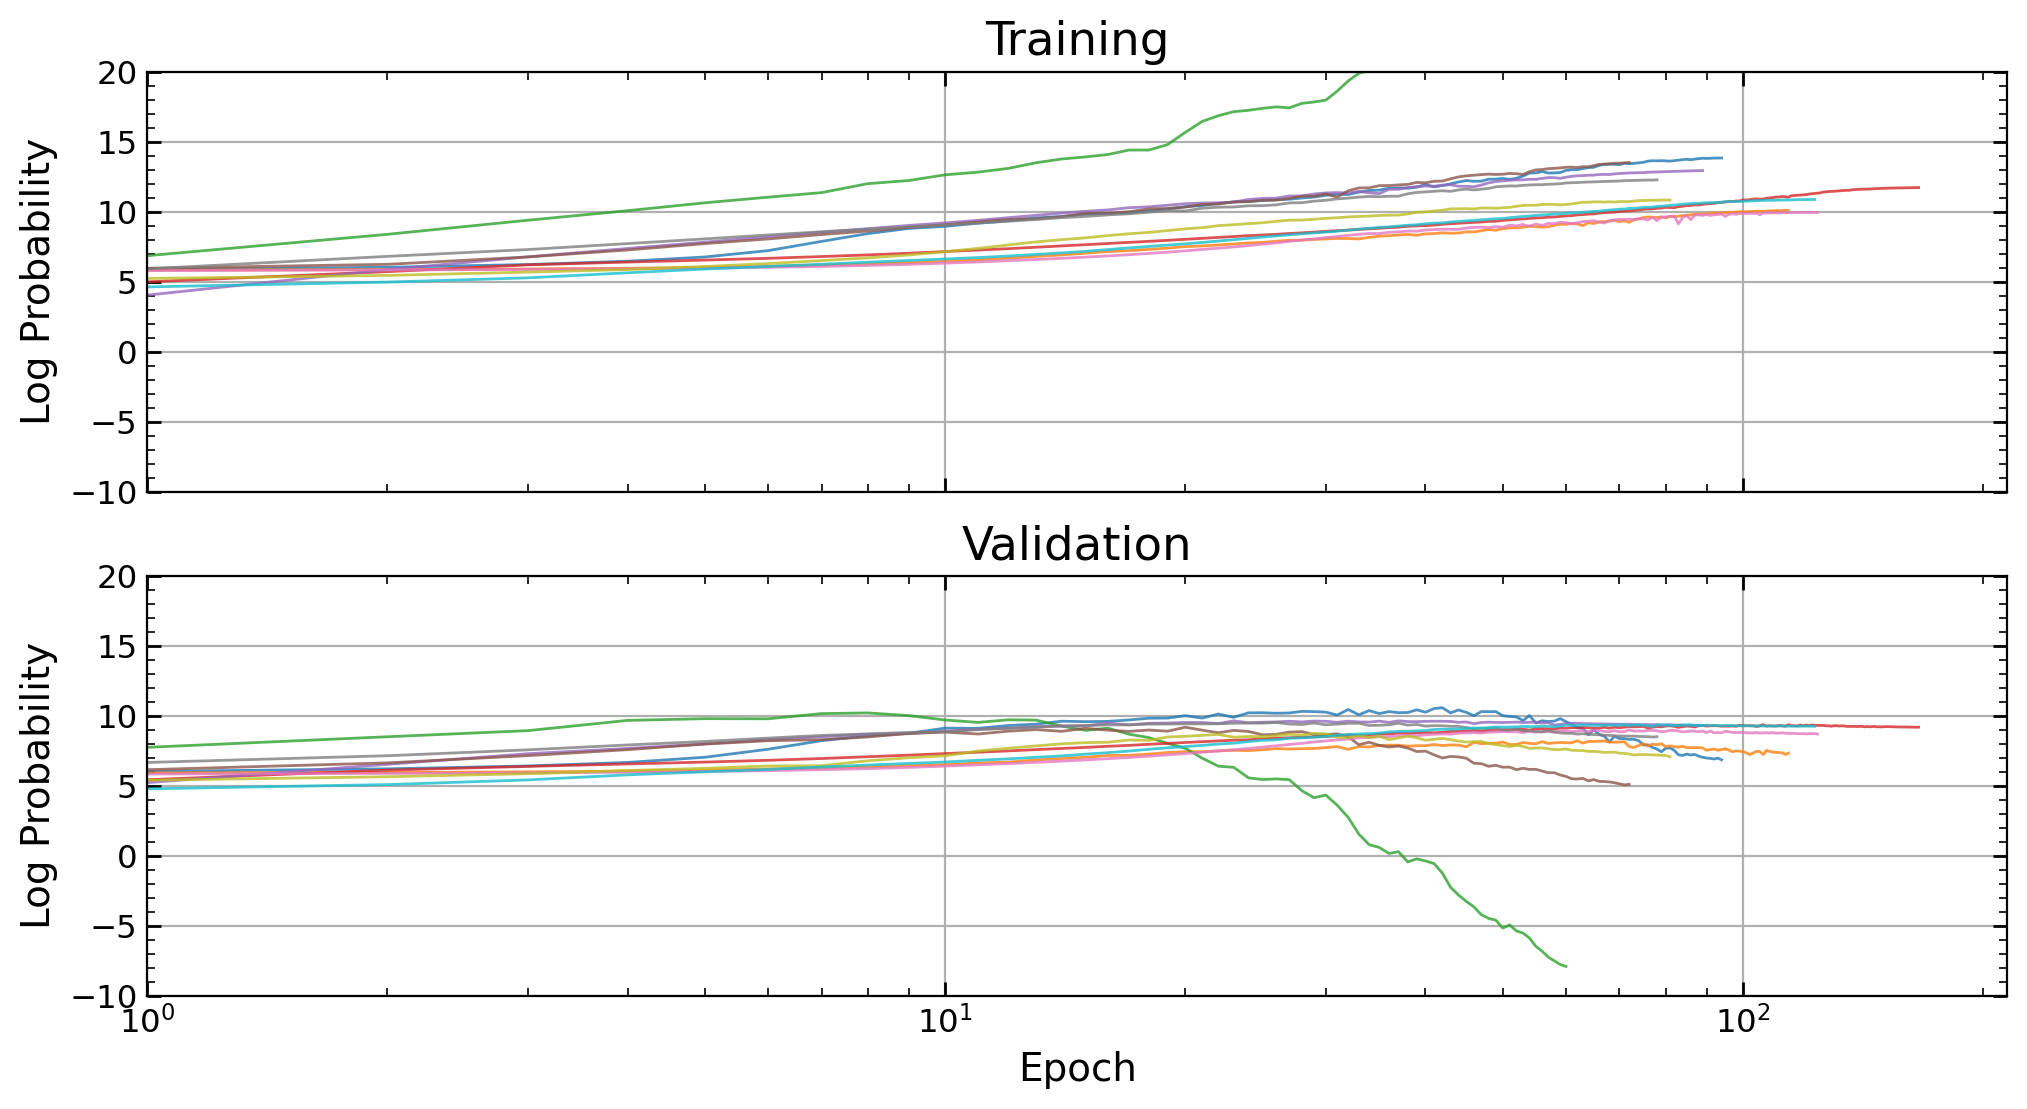

In [8]:
ss = 10

netpath = join(modelpath, 'nets')
netlist = os.listdir(netpath)

f, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)

for n in tqdm(netlist[::ss]):
    filepath = join(netpath, n, 'summary.json')
    if not os.path.exists(filepath):
        continue
    with open(filepath, 'r') as f:
        history = json.load(f)
    
    x_ = range(1, len(history[0]['training_log_probs'])+1)
    
    ax = axs[0]
    ax.plot(x_, history[0]['training_log_probs'], alpha=0.8, lw=1)

    ax = axs[1]
    ax.plot(x_, history[0]['validation_log_probs'], alpha=0.8, lw=1)

ax.semilogx()
ax.set_xlim(1)
ax.set_ylim(-10, 20)

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[0].grid()
axs[1].grid()

axs[0].set(ylabel='Log Probability')
axs[1].set(xlabel='Epoch', ylabel='Log Probability');

INFO:root:Sampling models with [290, 280, 210, 210, 184, 178, 177, 163, 160, 153] samples each.
Drawing 290 posterior samples: 467it [00:11, 39.11it/s]                         
Drawing 280 posterior samples: 487it [00:02, 184.14it/s]                         
Drawing 210 posterior samples: 389it [00:00, 5999.75it/s]             
Drawing 210 posterior samples: 353it [00:00, 6345.15it/s]             
Drawing 184 posterior samples: 192it [00:01, 184.30it/s]                       
Drawing 178 posterior samples: 223it [00:00, 34105.01it/s]            
Drawing 177 posterior samples: 178it [00:00, 4810.76it/s]             
Drawing 163 posterior samples: 204it [00:00, 4999.32it/s]             
Drawing 160 posterior samples:  44%|████▍     | 71/160 [00:00<00:00, 1039.28it/s]
Drawing 153 posterior samples: 159it [00:00, 4561.08it/s]             


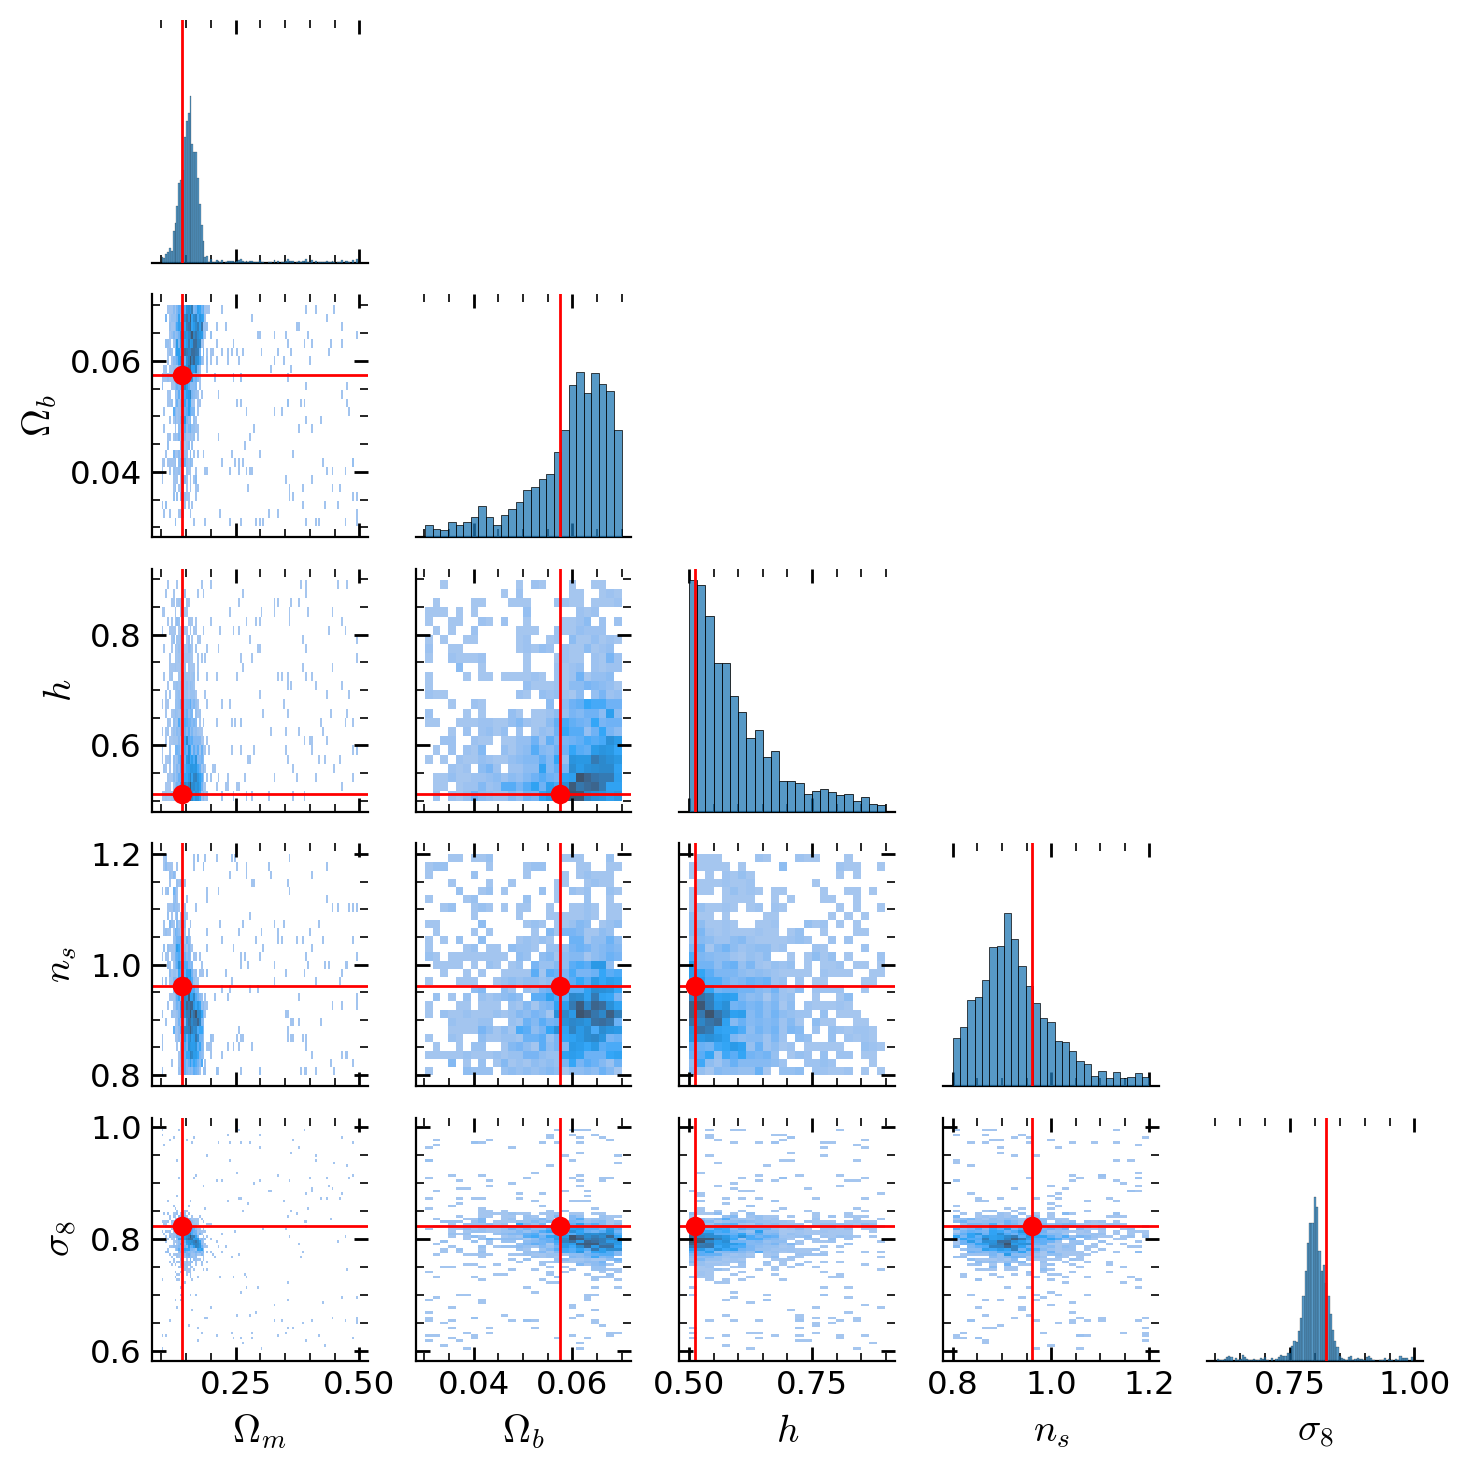

In [19]:
# Predict on a random test point
ind = 15
x0 = torch.Tensor(xtest[ind]).to(device)
y0 = ytest[ind]
samp0 = posterior.sample(x=x0, shape=(2000,))
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, y0, color='r', lw=1)

## Load an observed summary

In [9]:
# Load observed data
nbody = 'abacus'
sim = 'nbody'
save_dir = join(wdir, nbody, sim, 'models')
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')

xobs = np.load(join(modelpath, 'x_test.npy'))
yobs = np.load(join(modelpath, 'theta_test.npy'))
xid = np.load(join(modelpath, 'ids_test.npy'))

# xobs = xobs[::7]
# yobs = yobs[::7]
# xid = xid[::7]
xobs = xobs[:15]
yobs = yobs[:15]
xid = xid[:15]

In [26]:
np.argmax(np.abs(np.diff(xobs[0])))

125

(-5.0, 14.0)

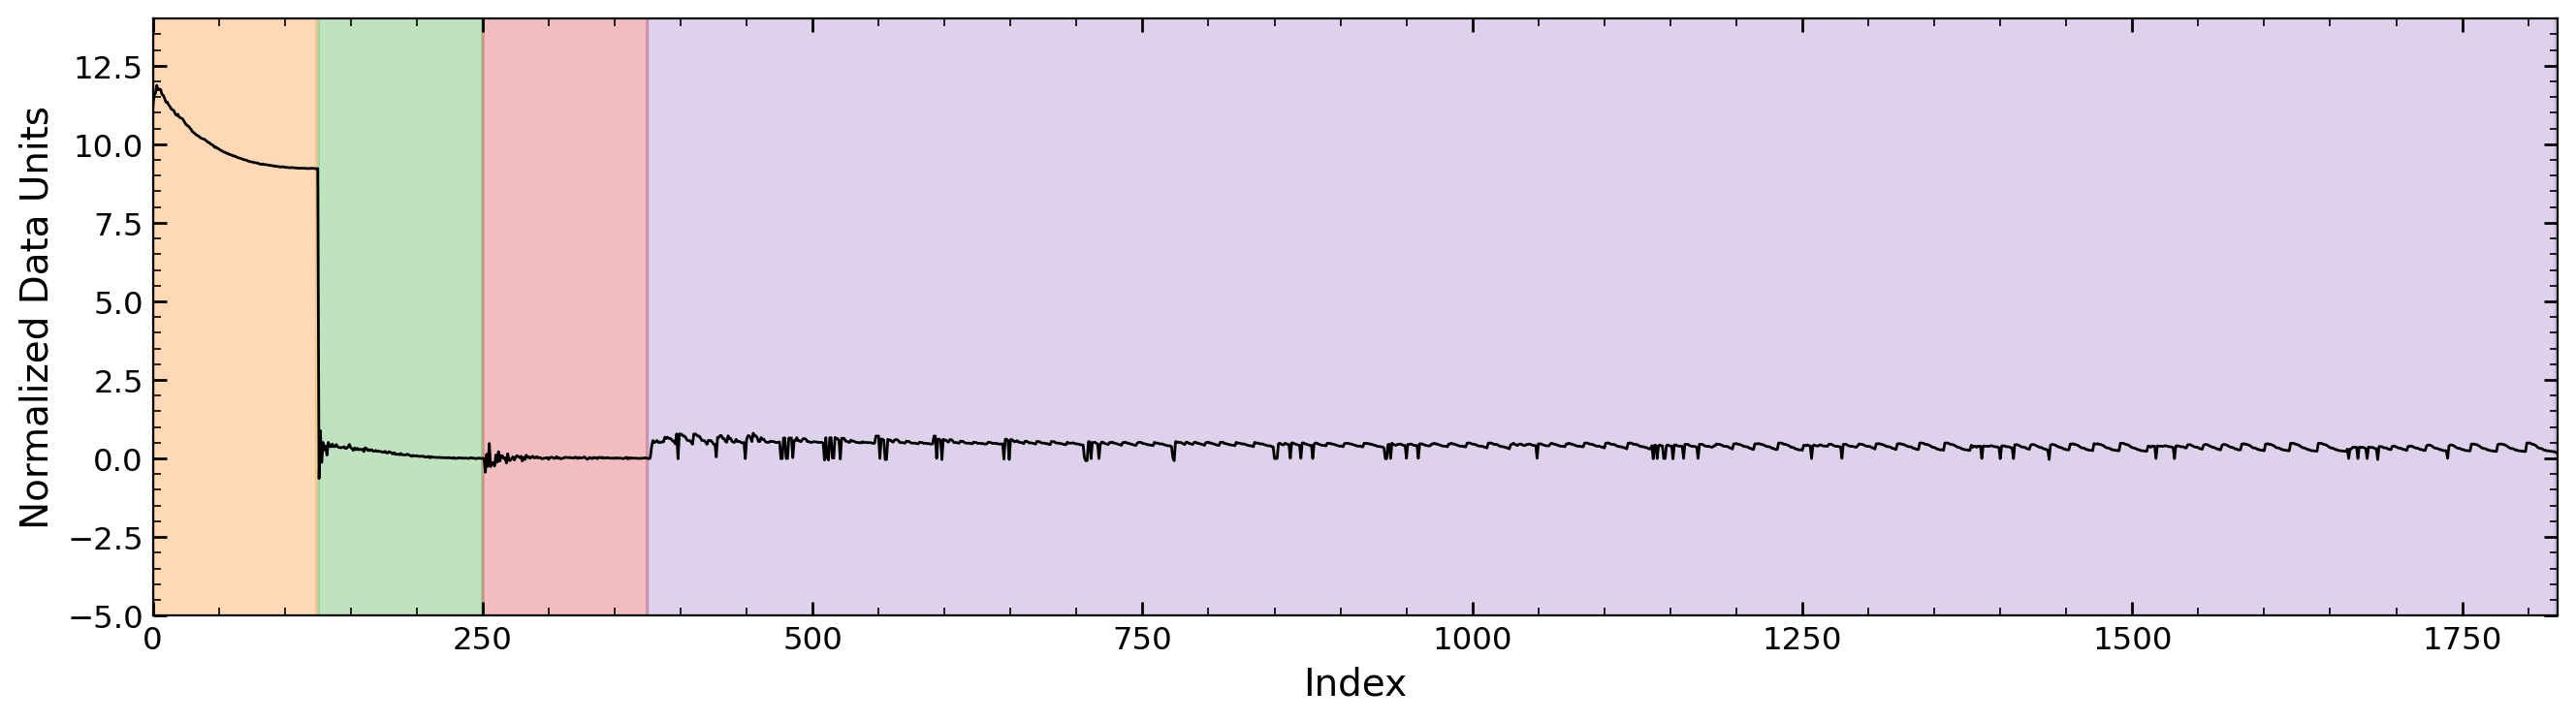

In [32]:
f, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(xobs[0], lw=1, c='k')

ax.fill_between(range(0, 125), -30, 30, color='C1', alpha=0.3)
ax.fill_between(range(125,250), -30, 30, color='C2', alpha=0.3)
ax.fill_between(range(250,375), -30, 30, color='C3', alpha=0.3)
ax.fill_between(range(375,len(xobs[0])), -30, 30, color='C4', alpha=0.3)

ax.set(xlabel='Index', ylabel='Normalized Data Units')
ax.set_xlim(0, len(xobs[0]))
ax.set_ylim(-5,14)

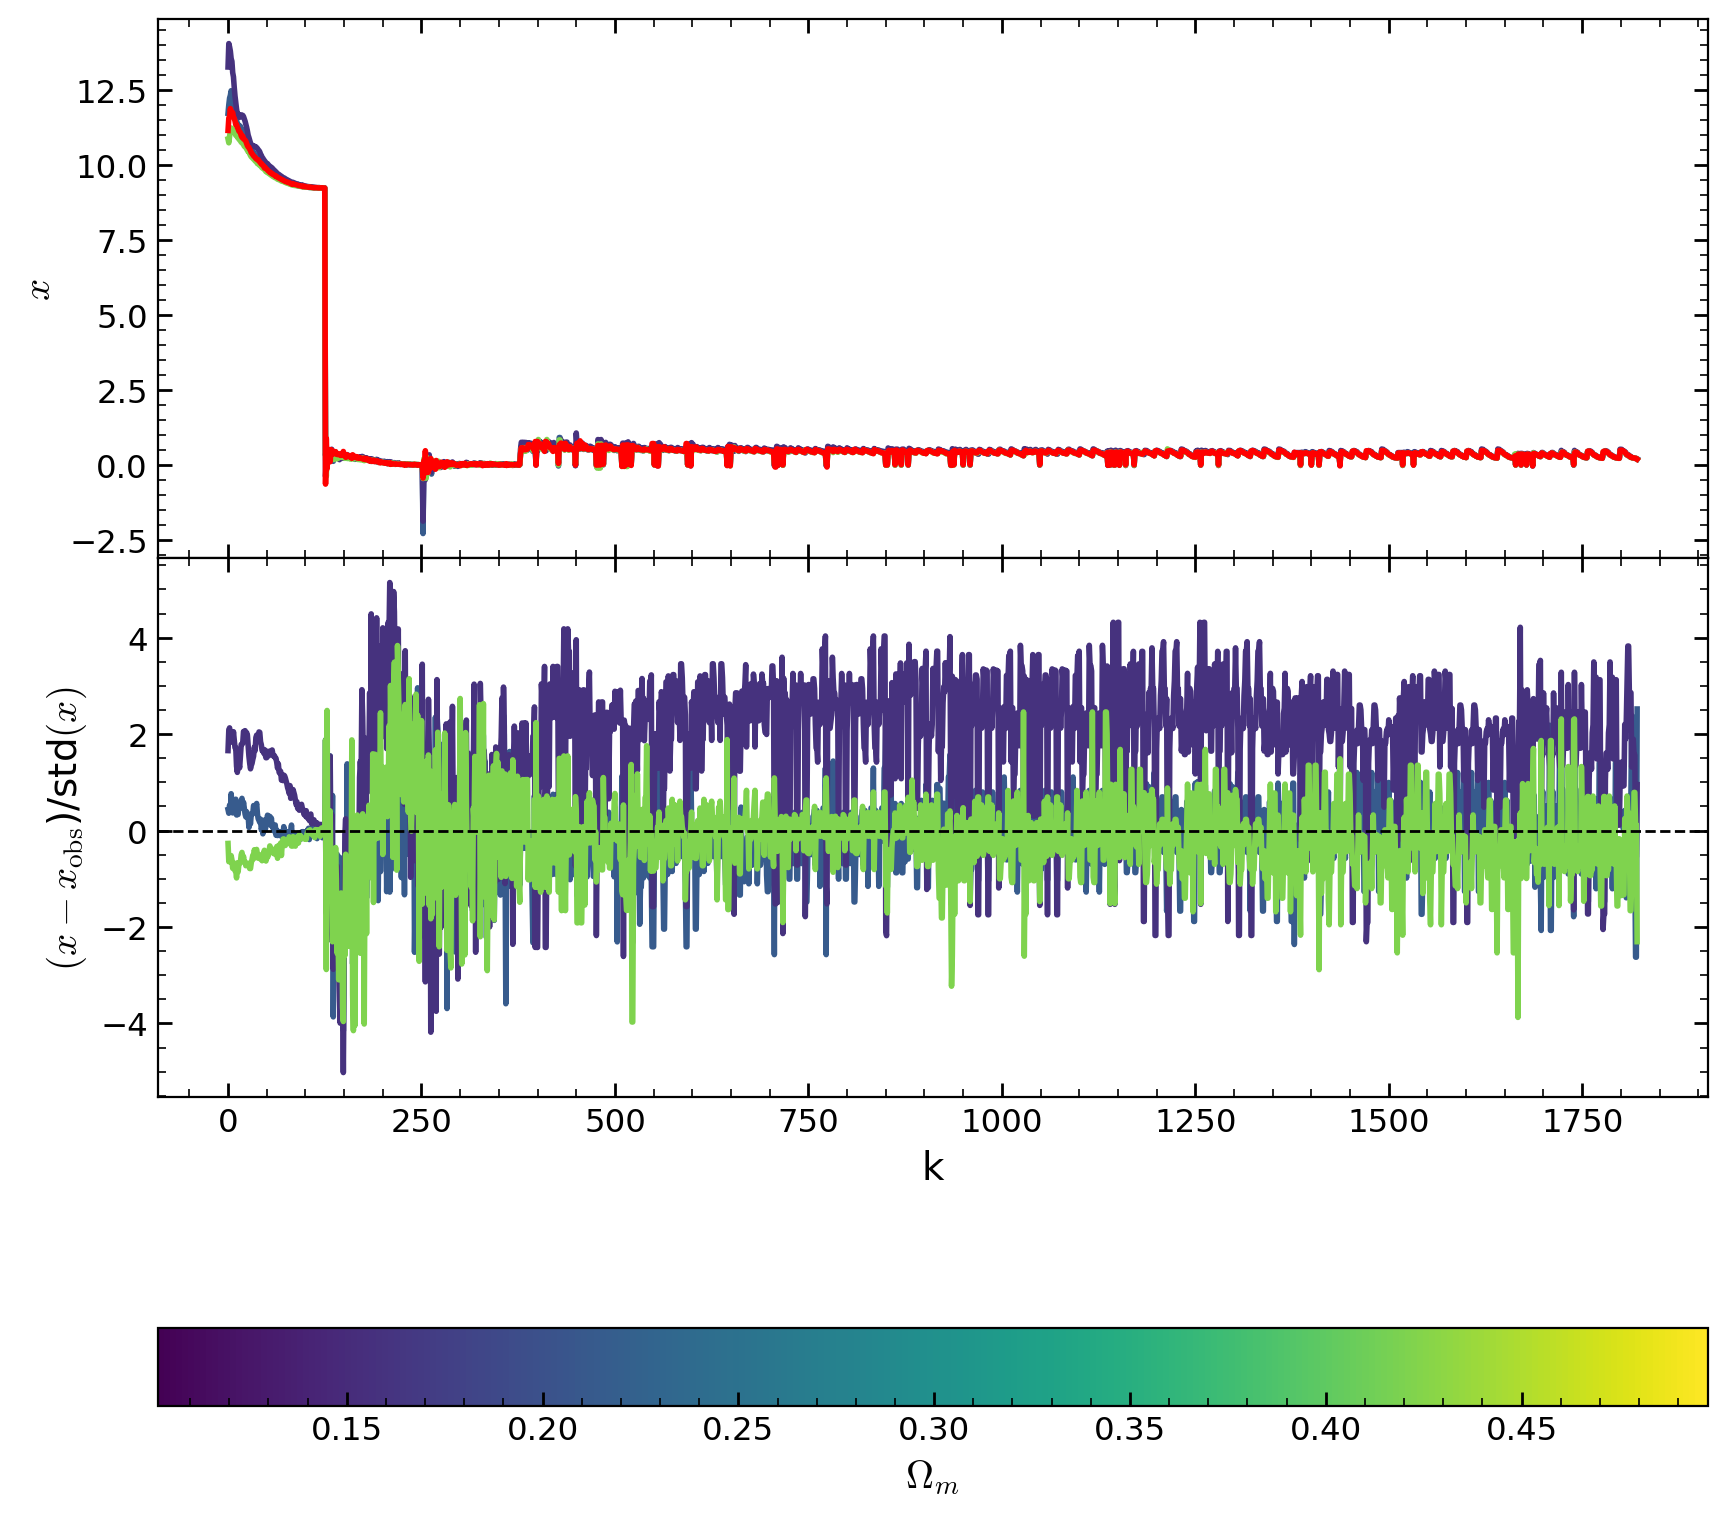

In [12]:
import matplotlib.colors as mcolors

ss = 5
ind = 0

f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, 
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xobs), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=2)
ax.set(ylabel=r'$x$')

ax  = axs[1]
for i in range(0, len(xobs), ss):
    ax.plot((xtest[i]-xobs[i])/np.std(xtest, axis=0), color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='k', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=axs, orientation='horizontal')
cbar.set_label(r'$\Omega_m$')

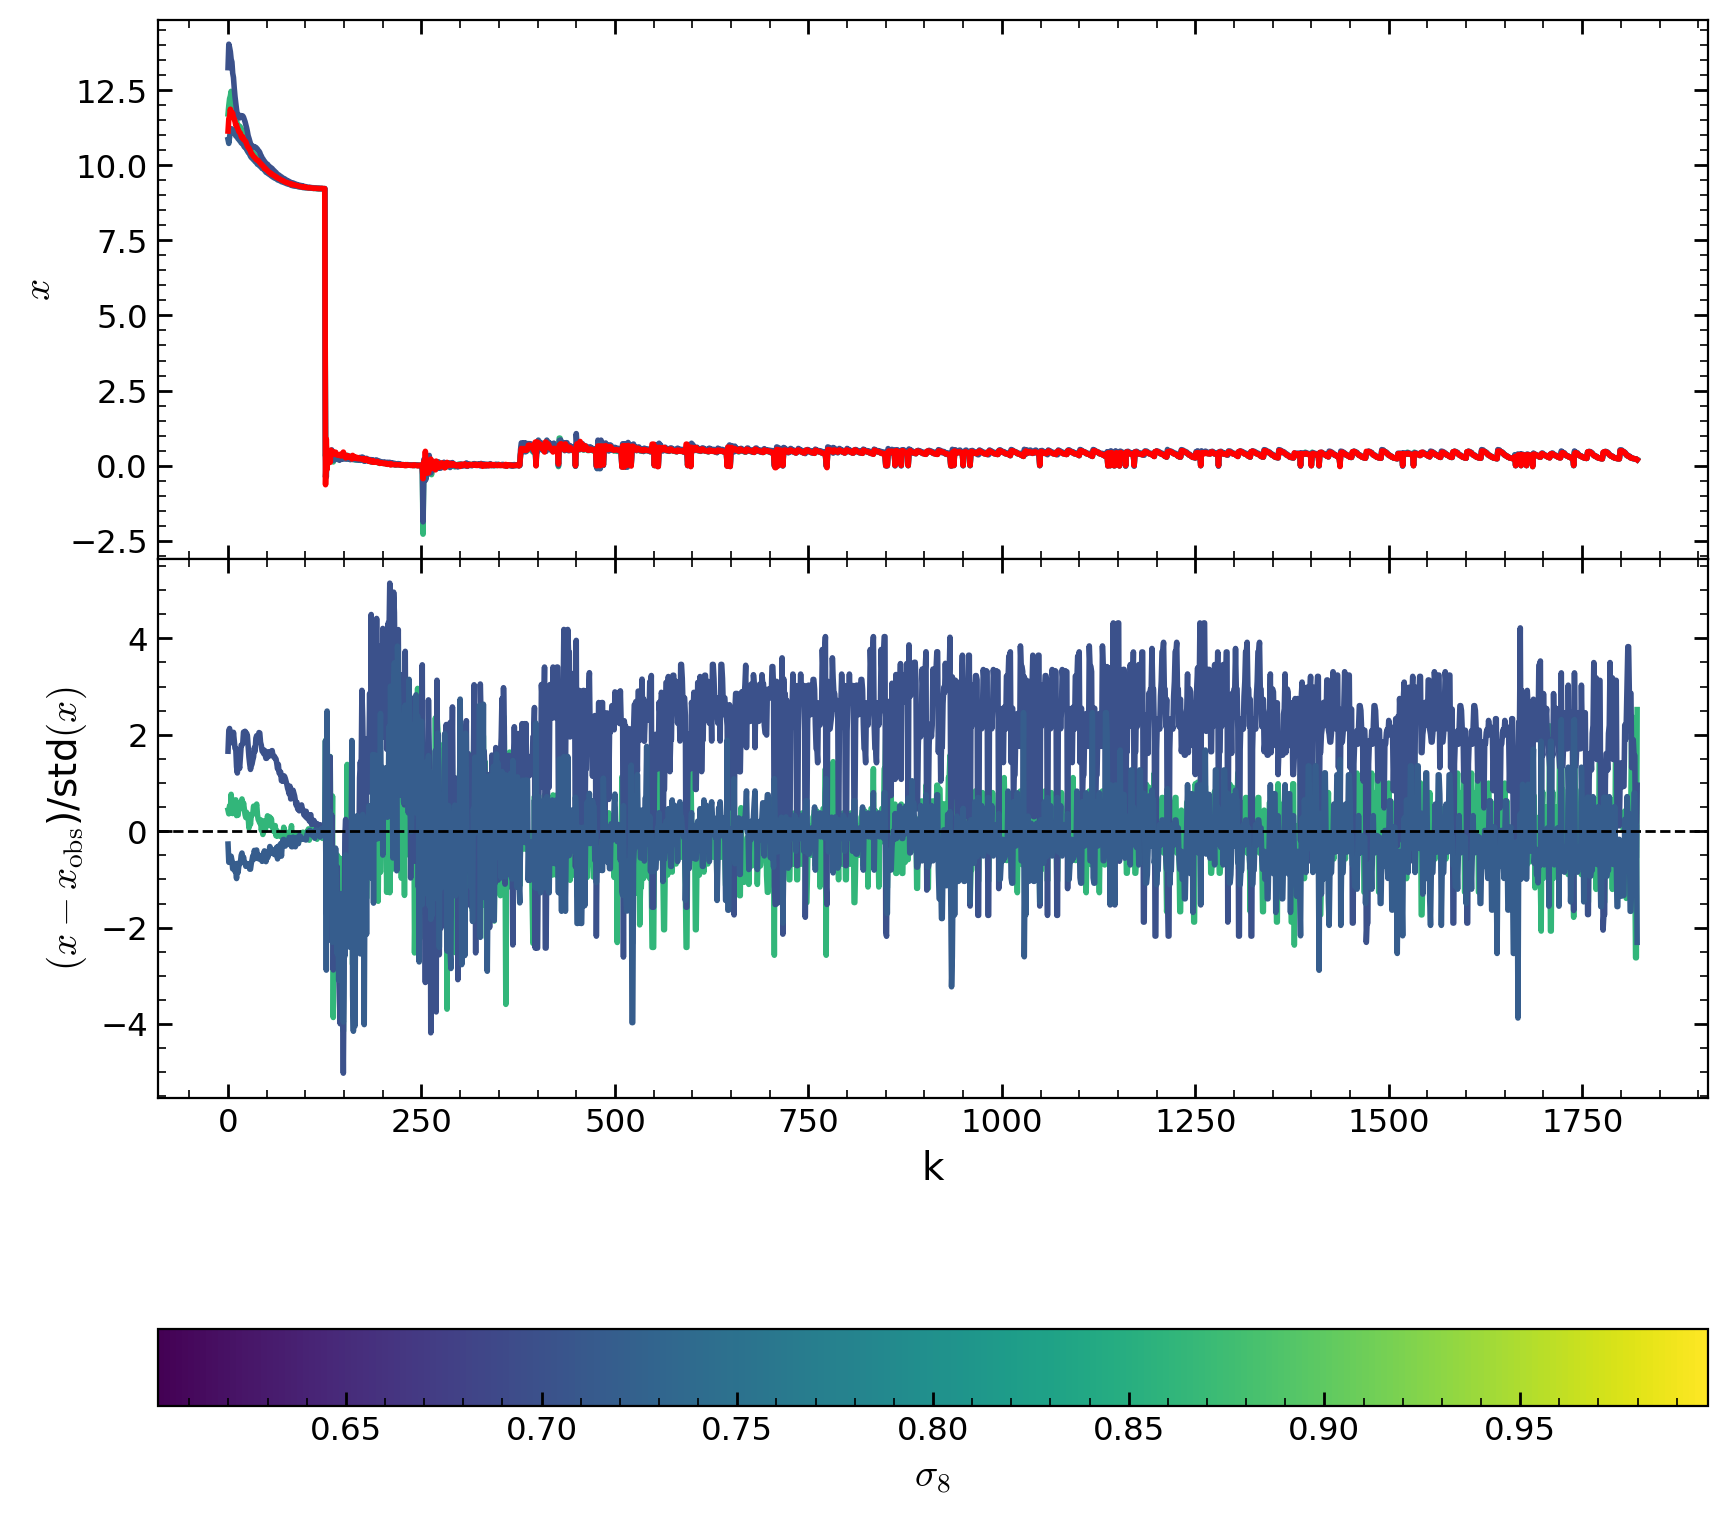

In [36]:
import matplotlib.colors as mcolors

ss = 5
ind = 0

f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, 
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 4]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xobs), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=2)
ax.set(ylabel=r'$x$')

ax  = axs[1]
for i in range(0, len(xobs), ss):
    ax.plot((xtest[i]-xobs[i])/np.std(xtest, axis=0), color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='k', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=axs, orientation='horizontal')
cbar.set_label(r'$\sigma_8$')

INFO:root:Sampling models with [289, 280, 210, 209, 184, 178, 177, 163, 160, 153] samples each.
Drawing 289 posterior samples: 477it [00:10, 44.30it/s]                         
Drawing 280 posterior samples: 543it [00:01, 541.39it/s]                         
Drawing 210 posterior samples: 377it [00:00, 5985.47it/s]             
Drawing 209 posterior samples: 380it [00:00, 6878.46it/s]             
Drawing 184 posterior samples: 310it [00:00, 10747.69it/s]            
Drawing 178 posterior samples: 317it [00:00, 72922.41it/s]            
Drawing 177 posterior samples: 323it [00:00, 8708.92it/s]             
Drawing 163 posterior samples: 272it [00:00, 8590.16it/s]             
Drawing 160 posterior samples: 293it [00:00, 6598.25it/s]             
Drawing 153 posterior samples: 283it [00:00, 8596.07it/s]             


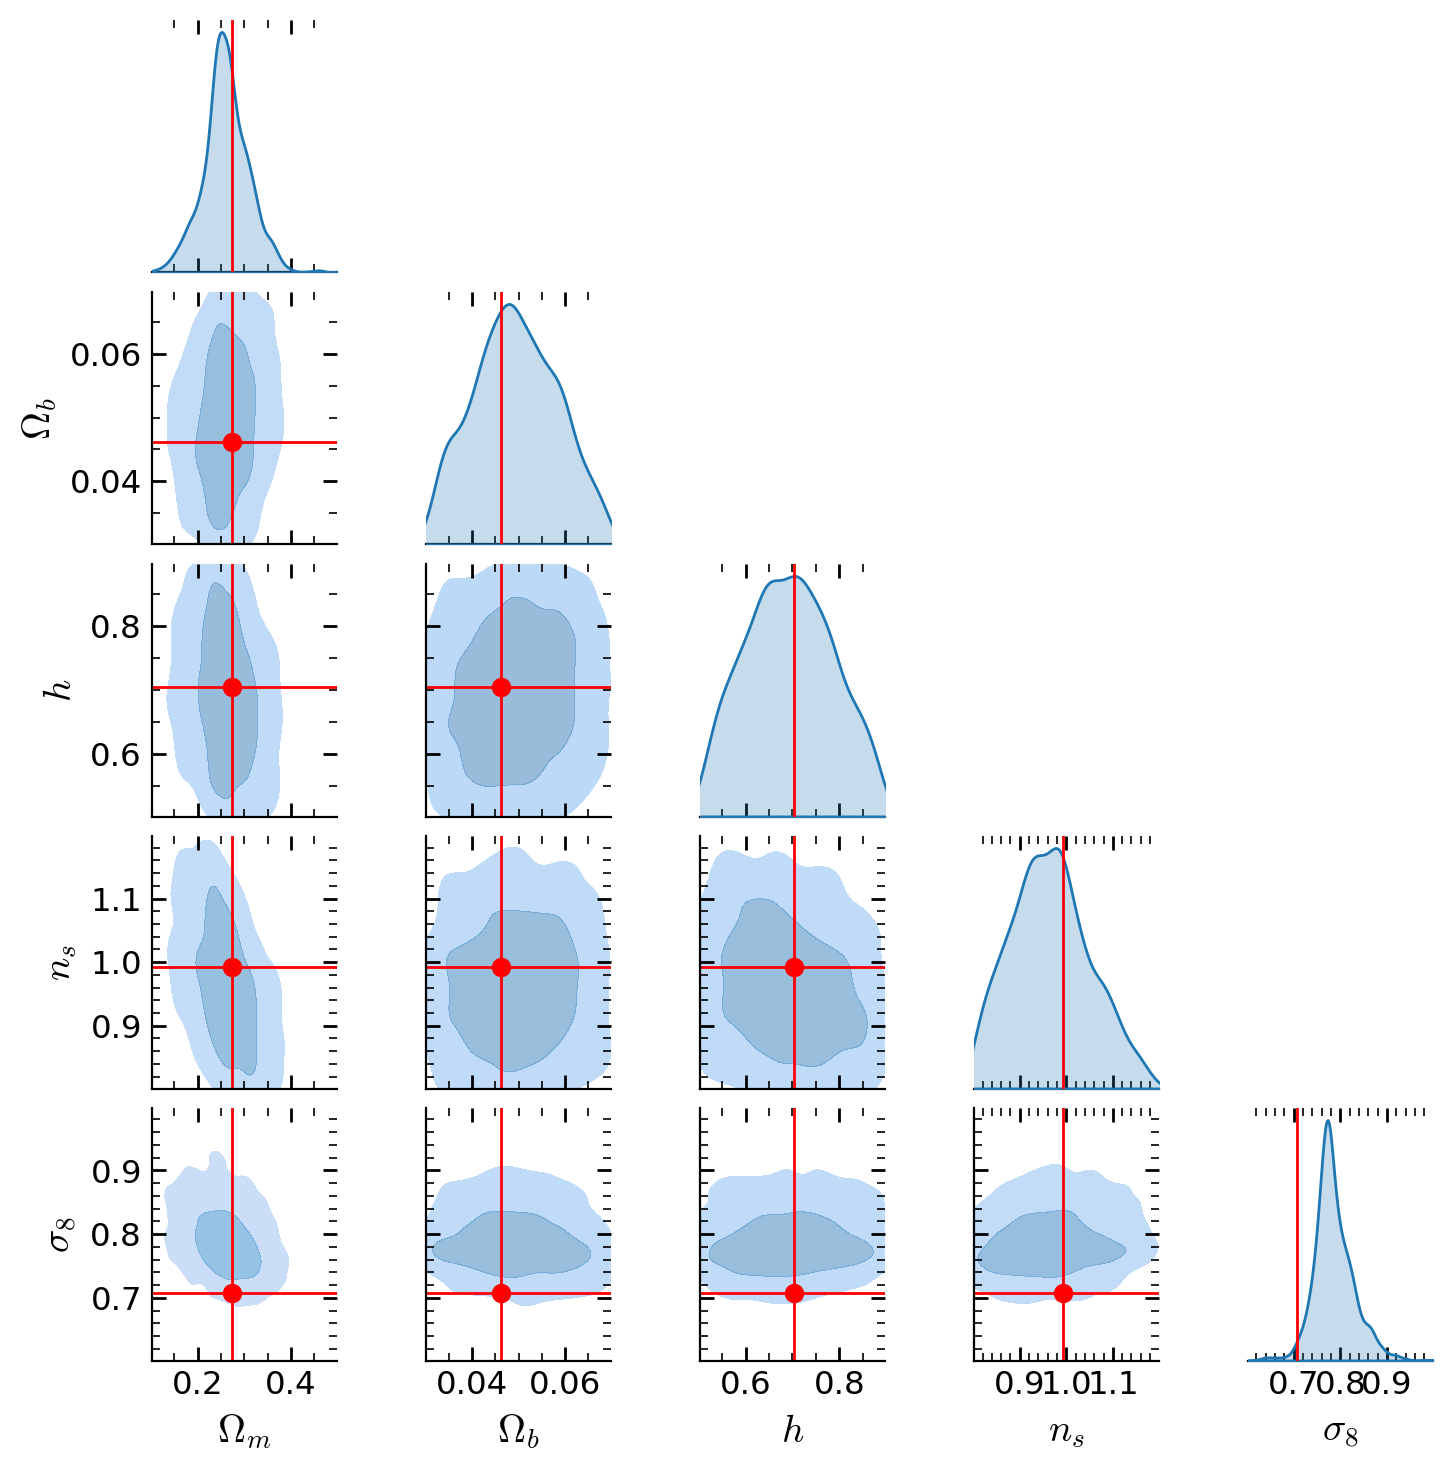

In [37]:
# Predict on a random test point
ind = 11
samp0 = posterior.sample(x=xobs[ind], shape=(1999,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


def set_boundaries(grid, prior_range):
    for i, (x, y) in enumerate(prior_range):
        grid.diag_axes[i].set_xlim(x, y)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.set_ylim(x, y)
                ax.set_xlim(*prior_range[j])


g = sns.pairplot(
    samp0,
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, yobs[ind], color='r', lw=1)
set_boundaries(g, yrange)

## Compare to literature

In [34]:
# Load literature
import pandas as pd

# ivanov
iva = pd.read_csv(
    '/anvil/scratch/x-mho1/cmass-ili/literature/processed/ivanov.csv')
iva = iva.drop('chain', axis=1)

# simbig
sbpk = pd.read_csv(
    '/anvil/scratch/x-mho1/cmass-ili/literature/processed/simbig_pk.csv')


# our work
ltu = pd.DataFrame(samp0.values[:, :5], columns=iva.columns)

In [ ]:
np.mean(sbpk.values[:, :], axis=0)

array([0.28747646, 0.04364681, 0.71466066, 0.93398812, 0.80653615])

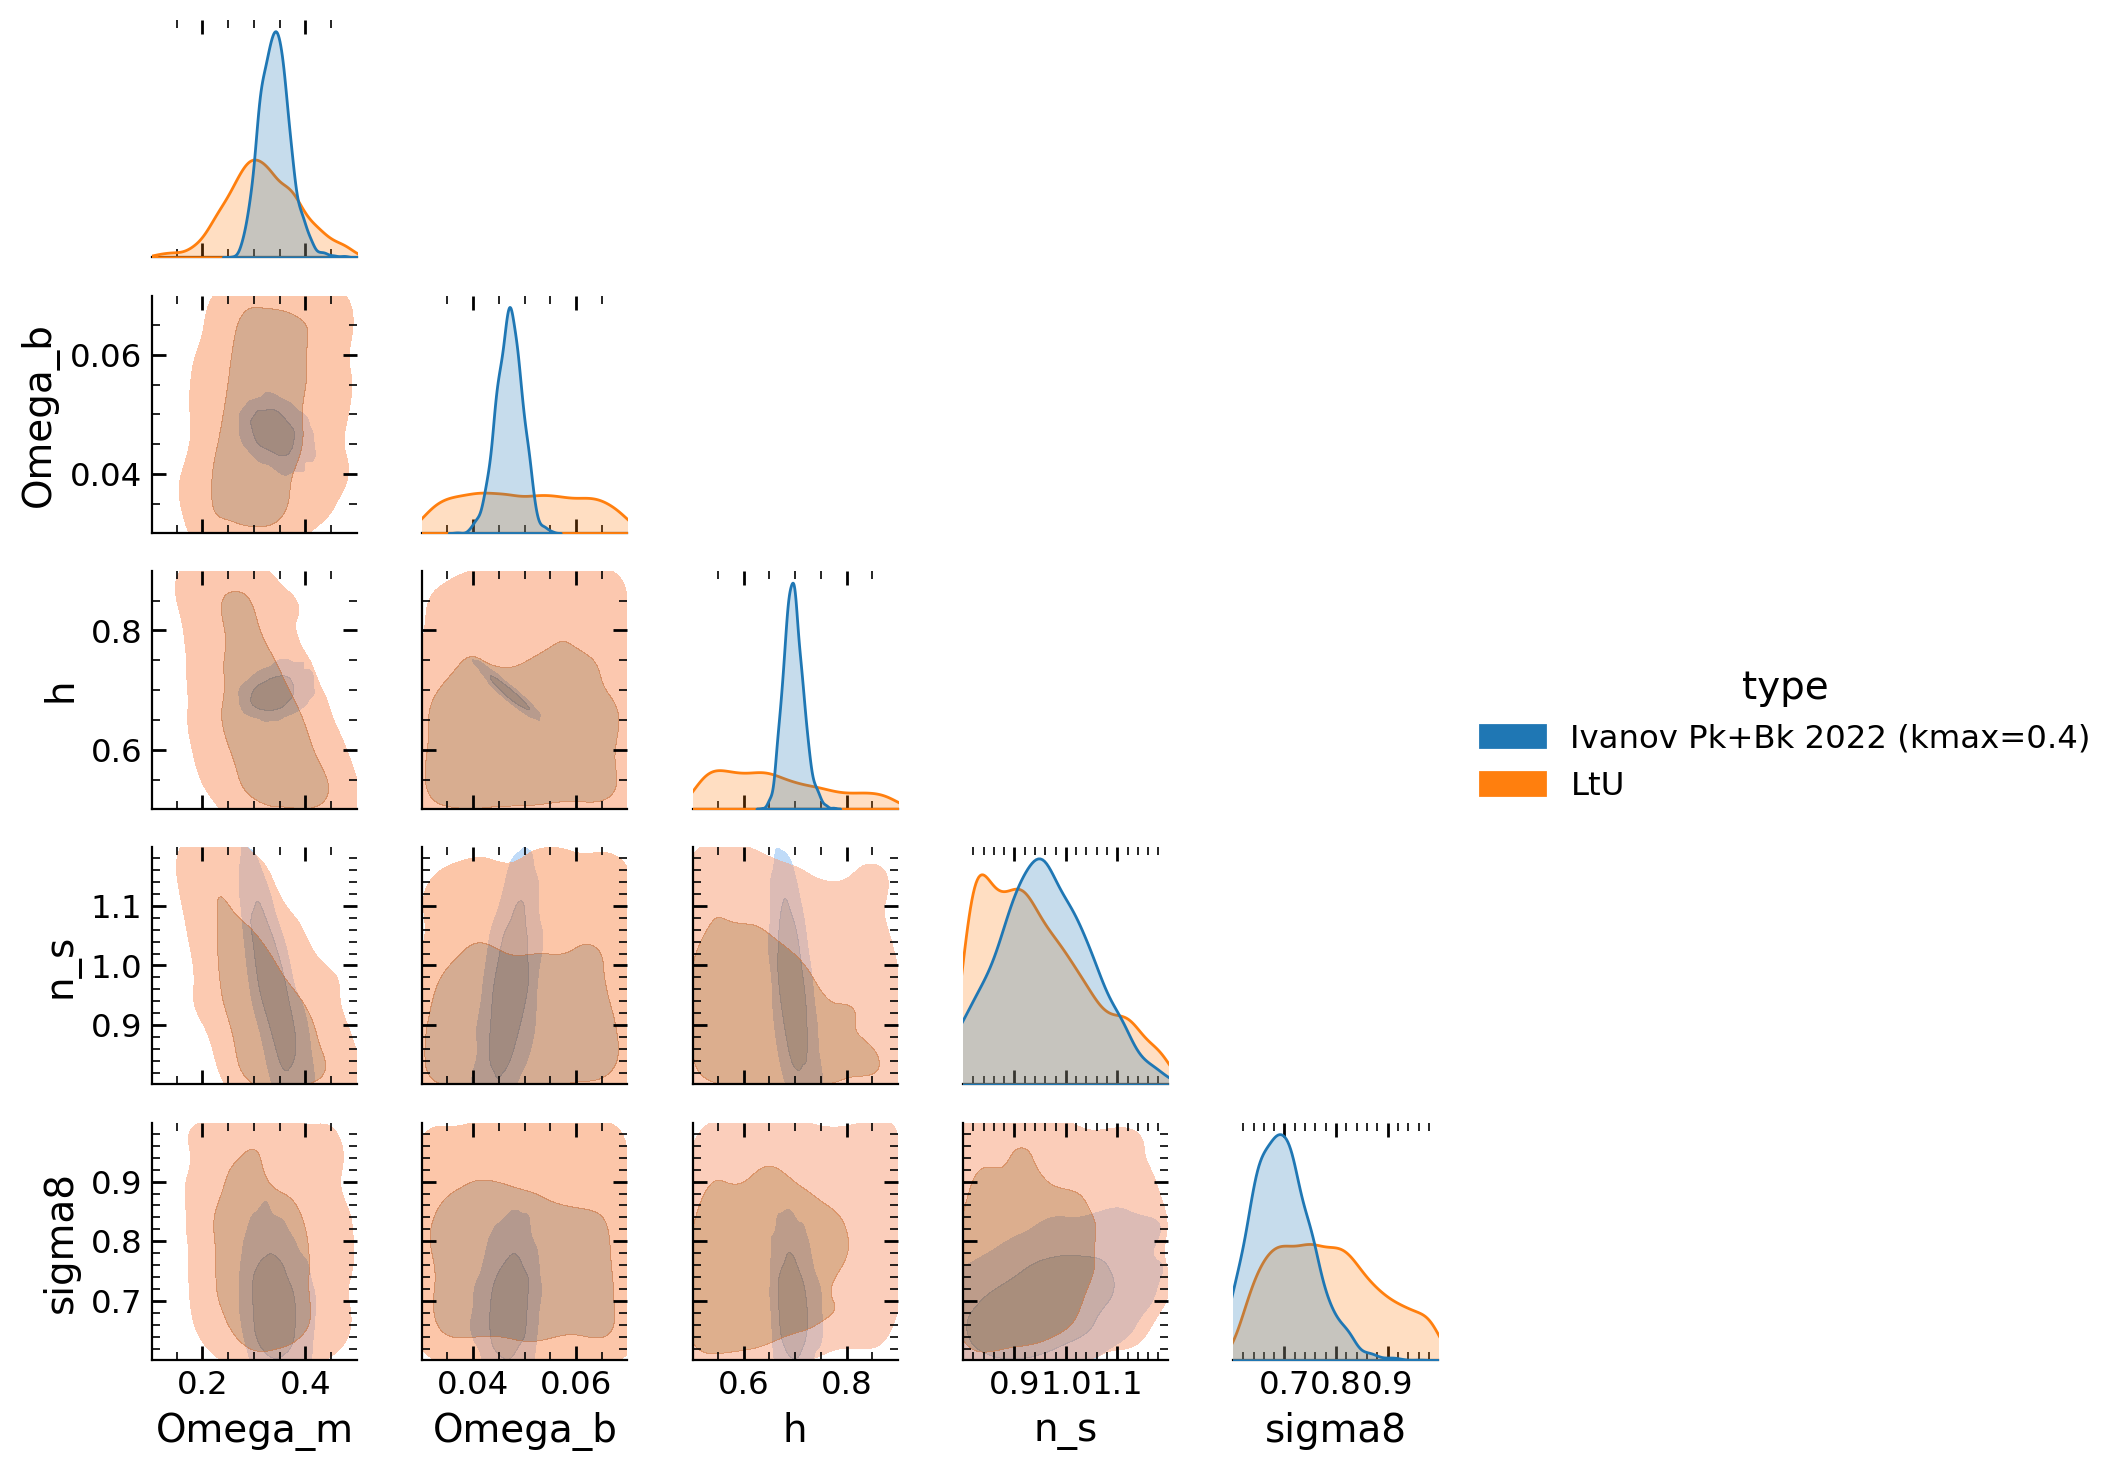

In [36]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns

iva['type'] = 'Ivanov Pk+Bk 2022 (kmax=0.4)'
ltu['type'] = 'LtU'
sbpk['type'] = 'SimBIG Pk (kmax=0.5)'

out = pd.concat([iva[:len(ltu)], ltu]).reset_index(drop=True)

g = sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)
set_boundaries(g, yrange[:5])

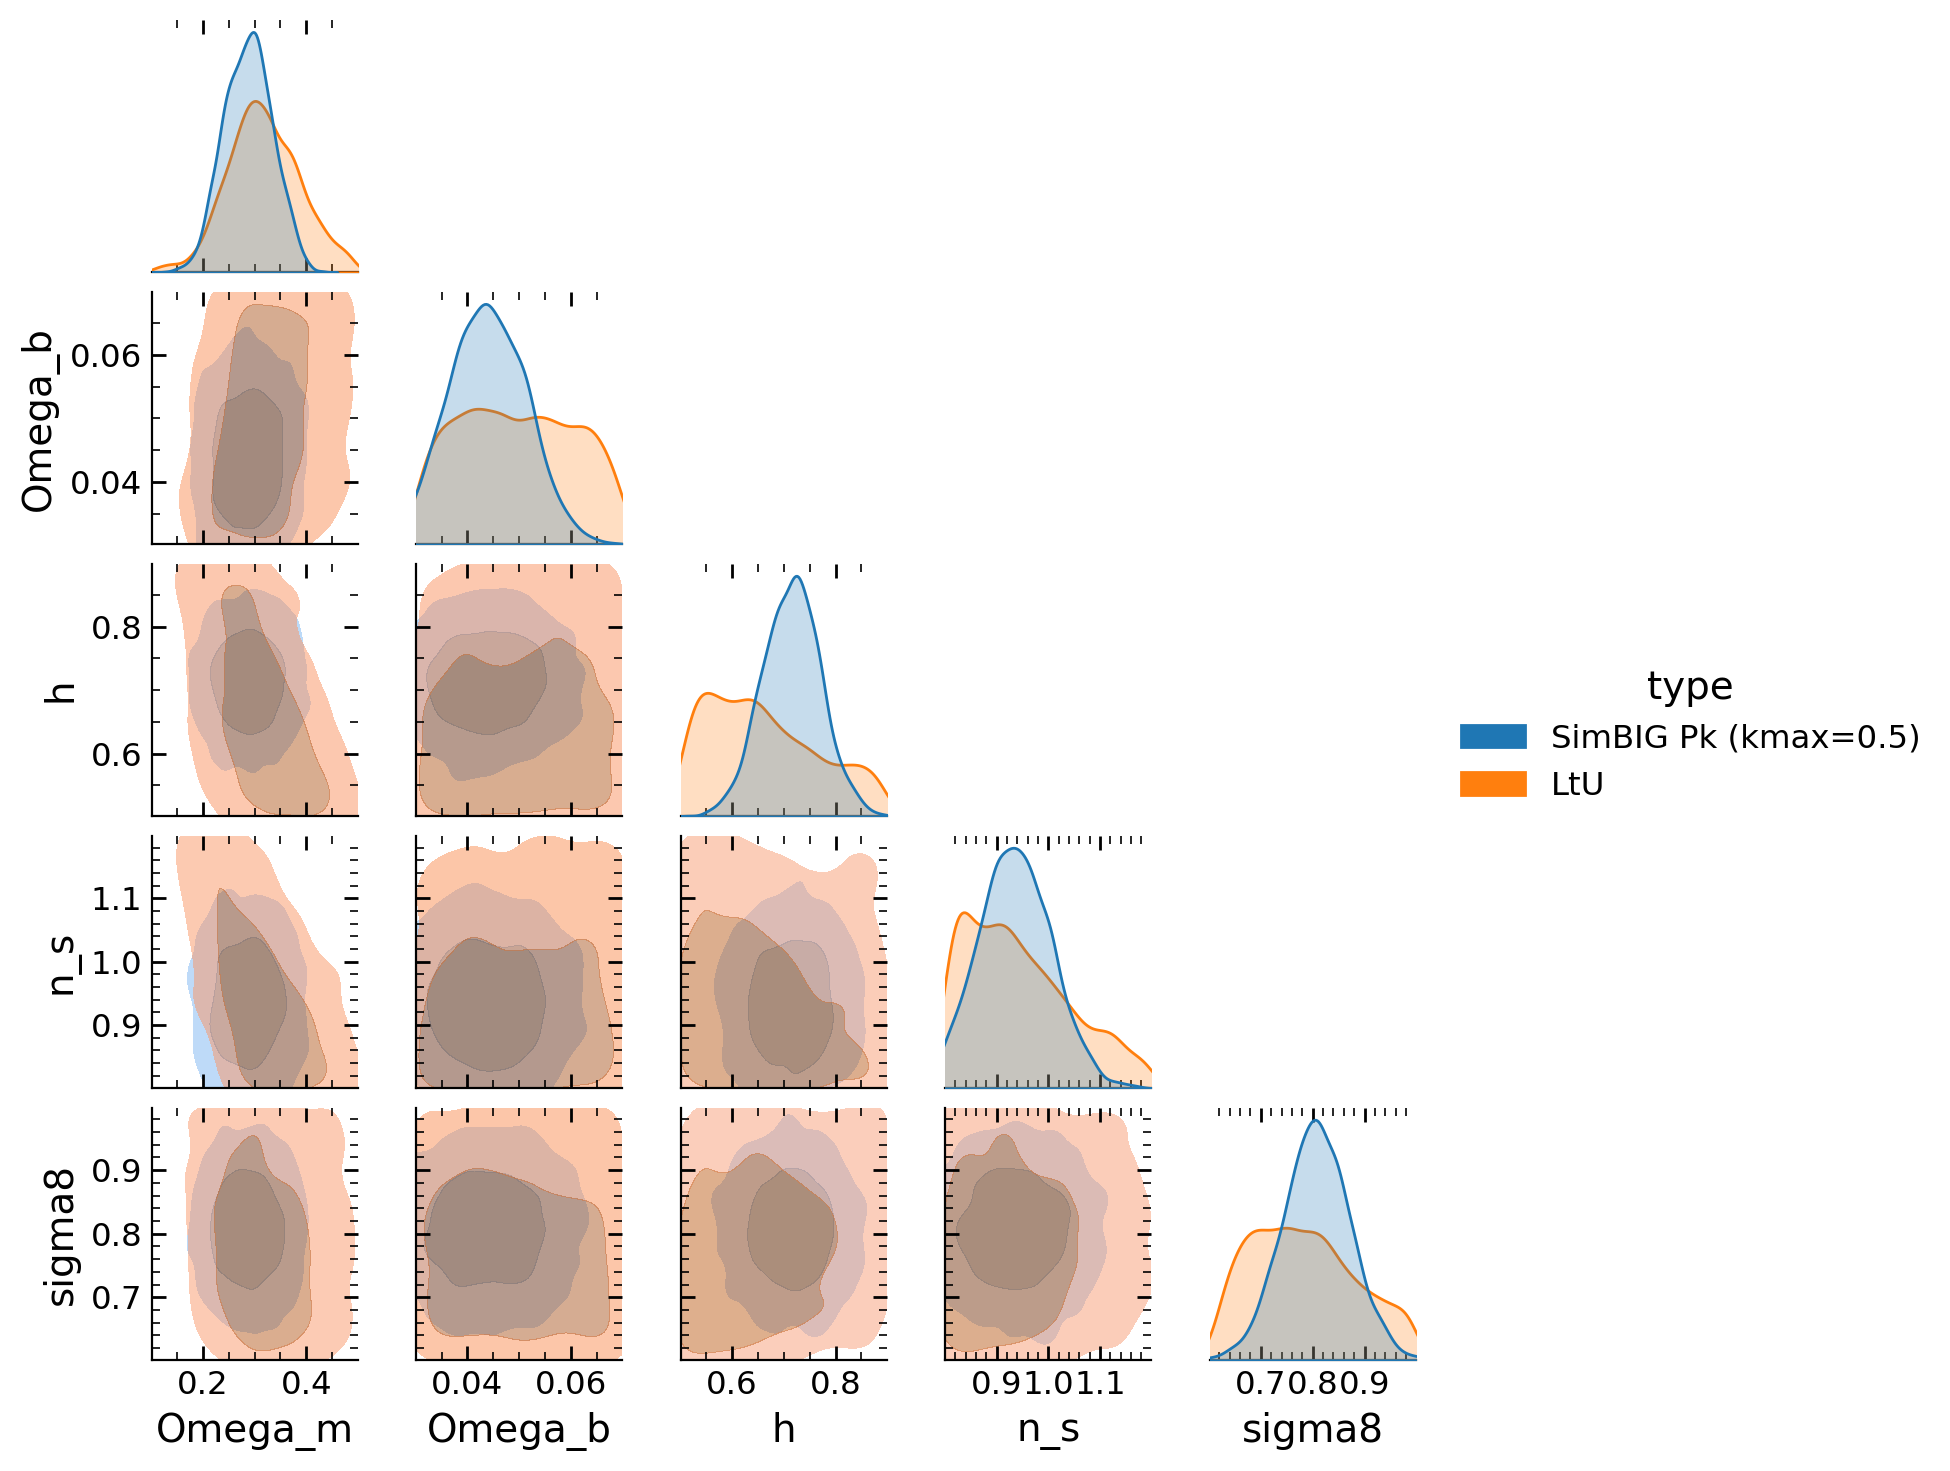

In [37]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns

iva['type'] = 'Ivanov Pk+Bk 2022 (kmax=0.4)'
ltu['type'] = 'LtU'
sbpk['type'] = 'SimBIG Pk (kmax=0.5)'

out = pd.concat([sbpk[:len(ltu)], ltu]).reset_index(drop=True)

g = sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)
set_boundaries(g, yrange[:5])

## Predict on a suite of summaries

In [38]:
samps = []
for xin in tqdm(xobs):
    samp = posterior.sample(x=xin, shape=(1000,), show_progress_bars=False).to('cpu')
    samps.append(samp)

100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


In [39]:
samps = np.array(samps)
trues = np.array(yobs)
# trues.shape, samps.shape

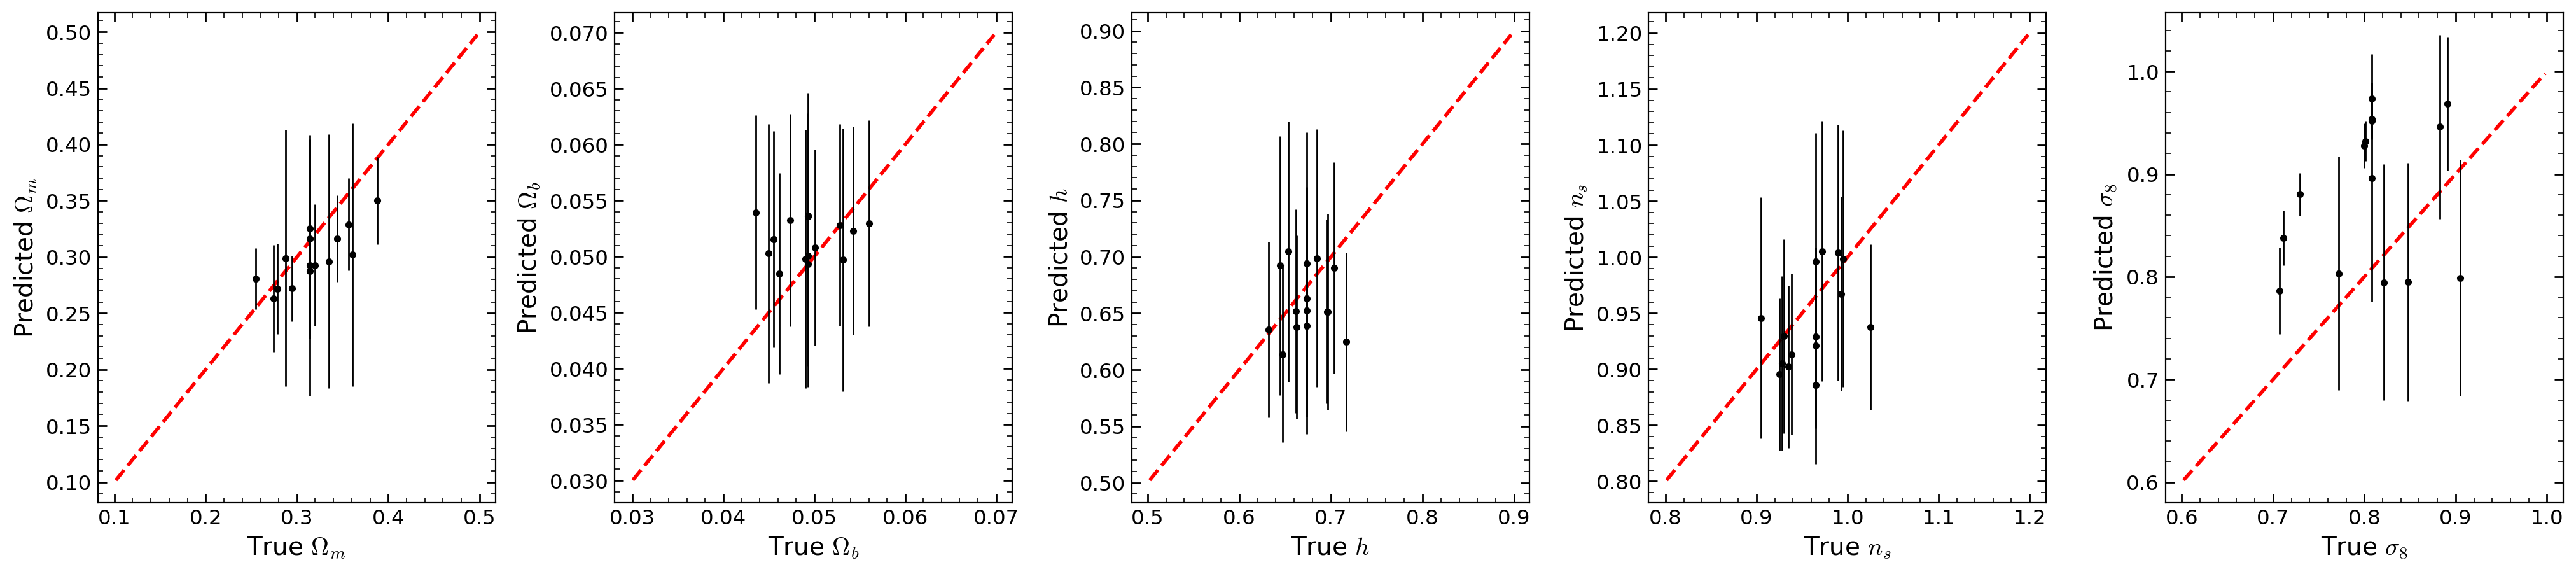

In [40]:
Nparams = trues.shape[-1]

H, W = 1, Nparams//1
f, axs = plt.subplots(H, W, figsize=(W*5, H*5), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()
for i in range(Nparams):
    means = np.average(samps[:, :, i], axis=1)
    stds = np.sqrt(np.average((samps[:, :, i] - means[:, None])**2, axis=1))
    axs[i].plot(yrange[i], yrange[i], 'r--')
    axs[i].plot(trues[:, i], means, 'k.')
    axs[i].errorbar(trues[:, i], means, yerr=stds, fmt='none', ecolor='k', elinewidth=1)
    axs[i].set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [115]:
samps = []
for xin in tqdm(xins):
    samp = posterior.sample(x=xin, shape=(1000,)).to('cpu')
    samps.append(samp)

  0%|          | 0/17 [00:00<?, ?it/s]INFO:root:Sampling models with [190, 148, 136, 131, 96, 66, 61, 60, 56, 56] samples each.
Drawing 190 posterior samples: 351it [00:01, 198.53it/s]                         
Drawing 148 posterior samples: 277it [00:05, 48.15it/s]
Drawing 136 posterior samples: 231it [00:05, 44.08it/s]
Drawing 131 posterior samples: 250it [00:04, 58.53it/s]
Drawing 96 posterior samples: 174it [00:05, 33.91it/s]
Drawing 66 posterior samples: 112it [00:03, 37.07it/s]
Drawing 61 posterior samples: 92it [00:00, 2766.08it/s]             
Drawing 60 posterior samples: 112it [00:00, 1896.00it/s]            
Drawing 56 posterior samples: 102it [00:00, 3369.37it/s]            
Drawing 56 posterior samples: 87it [00:00, 5373.35it/s]             
  6%|▌         | 1/17 [00:25<06:45, 25.35s/it]INFO:root:Sampling models with [190, 148, 136, 131, 96, 66, 61, 60, 56, 56] samples each.
Drawing 190 posterior samples: 345it [00:00, 7203.55it/s]             
Drawing 148 posterior samples

In [116]:
samps = np.array(samps)
trues = np.array(trues)
trues.shape, samps.shape

((17, 5), (17, 1000, 5))

In [117]:
weights = samps[:, :, 2]**4
weights /= weights.sum(axis=1)[:, None]

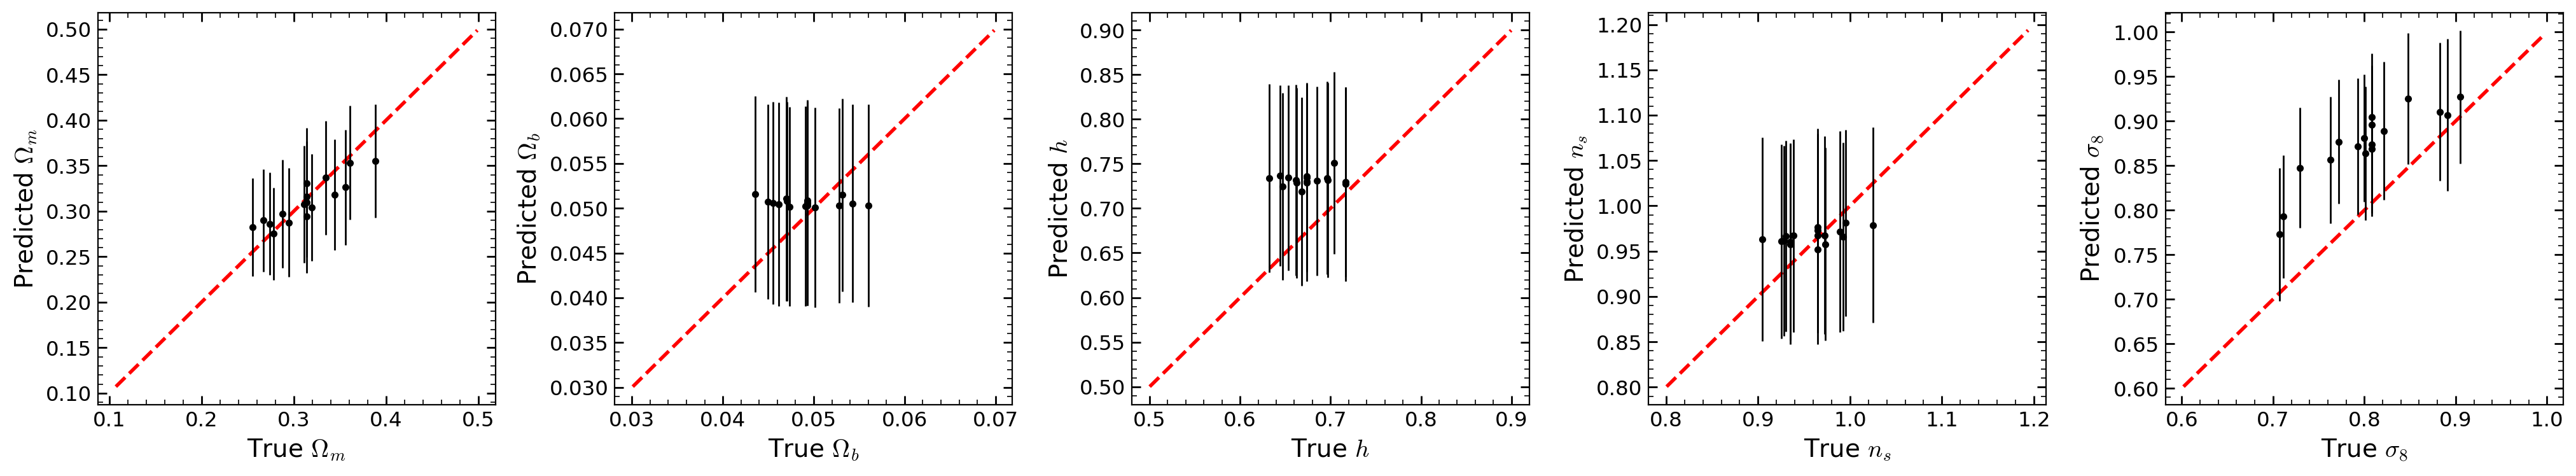

In [120]:
Nparams = trues.shape[-1]

f, axs = plt.subplots(1, Nparams, figsize=(5*Nparams, 4), gridspec_kw=dict(wspace=0.3))
for i in range(Nparams):
    means = np.average(samps[:, :, i], axis=1, weights=weights)
    stds = np.sqrt(np.average((samps[:, :, i] - means[:, None])**2, axis=1, weights=weights))
    axs[i].plot(yrange[i], yrange[i], 'r--')
    axs[i].plot(trues[:, i], means, 'k.')
    axs[i].errorbar(trues[:, i], means, yerr=stds, fmt='none', ecolor='k', elinewidth=1)
    axs[i].set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

## Predict across many

In [11]:
summaries = ['Pk0', 'Pk2']
tracer = 'halo'

In [13]:
# Load an observed summary
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 663
# summaries = ['Pk0', 'Pk2']

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}', 'diag')

summ = {}
with h5py.File(join(simpath, 'ngc_lightcone/hod06633_aug00000.h5'), 'r') as f:
    k = f['Pk_k3D'][:]
    for s in ['Pk0', 'Pk2', 'Pk4']:
        if s[:2] != 'Pk':
            raise NotImplementedError
        Pk = f['Pk'][:, int(s[-1])//2]  # get the pole
        summ[s] = [{'k': k, 'value': Pk}]
# a=f'{2/3:.6f}'
# with h5py.File(join(simpath, 'galaxies/hod20003.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     truehod = f.attrs['HOD_params']
#     trueparams = np.concatenate([truecosmo, truehod])
# with h5py.File(join(simpath, 'halos.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     # truehod = f.attrs['HOD_params']
#     trueparams = truecosmo # np.concatenate([truecosmo, truehod])

# truecosmo = [0.3175, 0.04900, 0.6711, 0.9624, 0.834]

In [98]:
from cmass.infer.loaders import preprocess_Pk


def load_and_predict(summaries=['Pk0', 'Pk2'], kmax=0.1):
    # Specify data dtype
    summary = '+'.join(summaries)
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
    print(modelpath)

    # Load model posterior
    p = load_posterior(modelpath)

    # Load losses
    summary_file = join(modelpath, 'summary.json')
    with open(summary_file, 'r') as f:
        history = json.load(f)

    # Preprocess observations
    xin = []
    for s in summaries:
        if s == 'Pk0':
            xs = preprocess_Pk(summ[s], kmax, monopole=True)
        else:
            xs = preprocess_Pk(summ[s], kmax, monopole=False, norm=summ['Pk0'])
        xin.append(xs)
    xin = np.array(xin).flatten()
    print(xin.shape)

    # Predict
    sampobs = p.sample(x=xin, shape=(1000,)).to('cpu')
    return sampobs, history

INFO:root:Sampling models with [454, 546] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.2
(190,)


Drawing 454 posterior samples: 822it [00:00, 17234.71it/s]            
Drawing 546 posterior samples: 792it [00:00, 51762.17it/s]            
INFO:root:Sampling models with [574, 426] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.3
(284,)


Drawing 574 posterior samples: 1068it [00:00, 21323.31it/s]           
Drawing 426 posterior samples: 734it [00:00, 47748.30it/s]            
INFO:root:Sampling models with [595, 405] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.4
(380,)


Drawing 595 posterior samples: 1085it [00:00, 20854.27it/s]           
Drawing 405 posterior samples: 645it [00:00, 40629.05it/s]            
INFO:root:Sampling models with [572, 428] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.5
(476,)


Drawing 572 posterior samples: 909it [00:00, 16591.12it/s]            
Drawing 428 posterior samples: 689it [00:00, 39331.41it/s]            


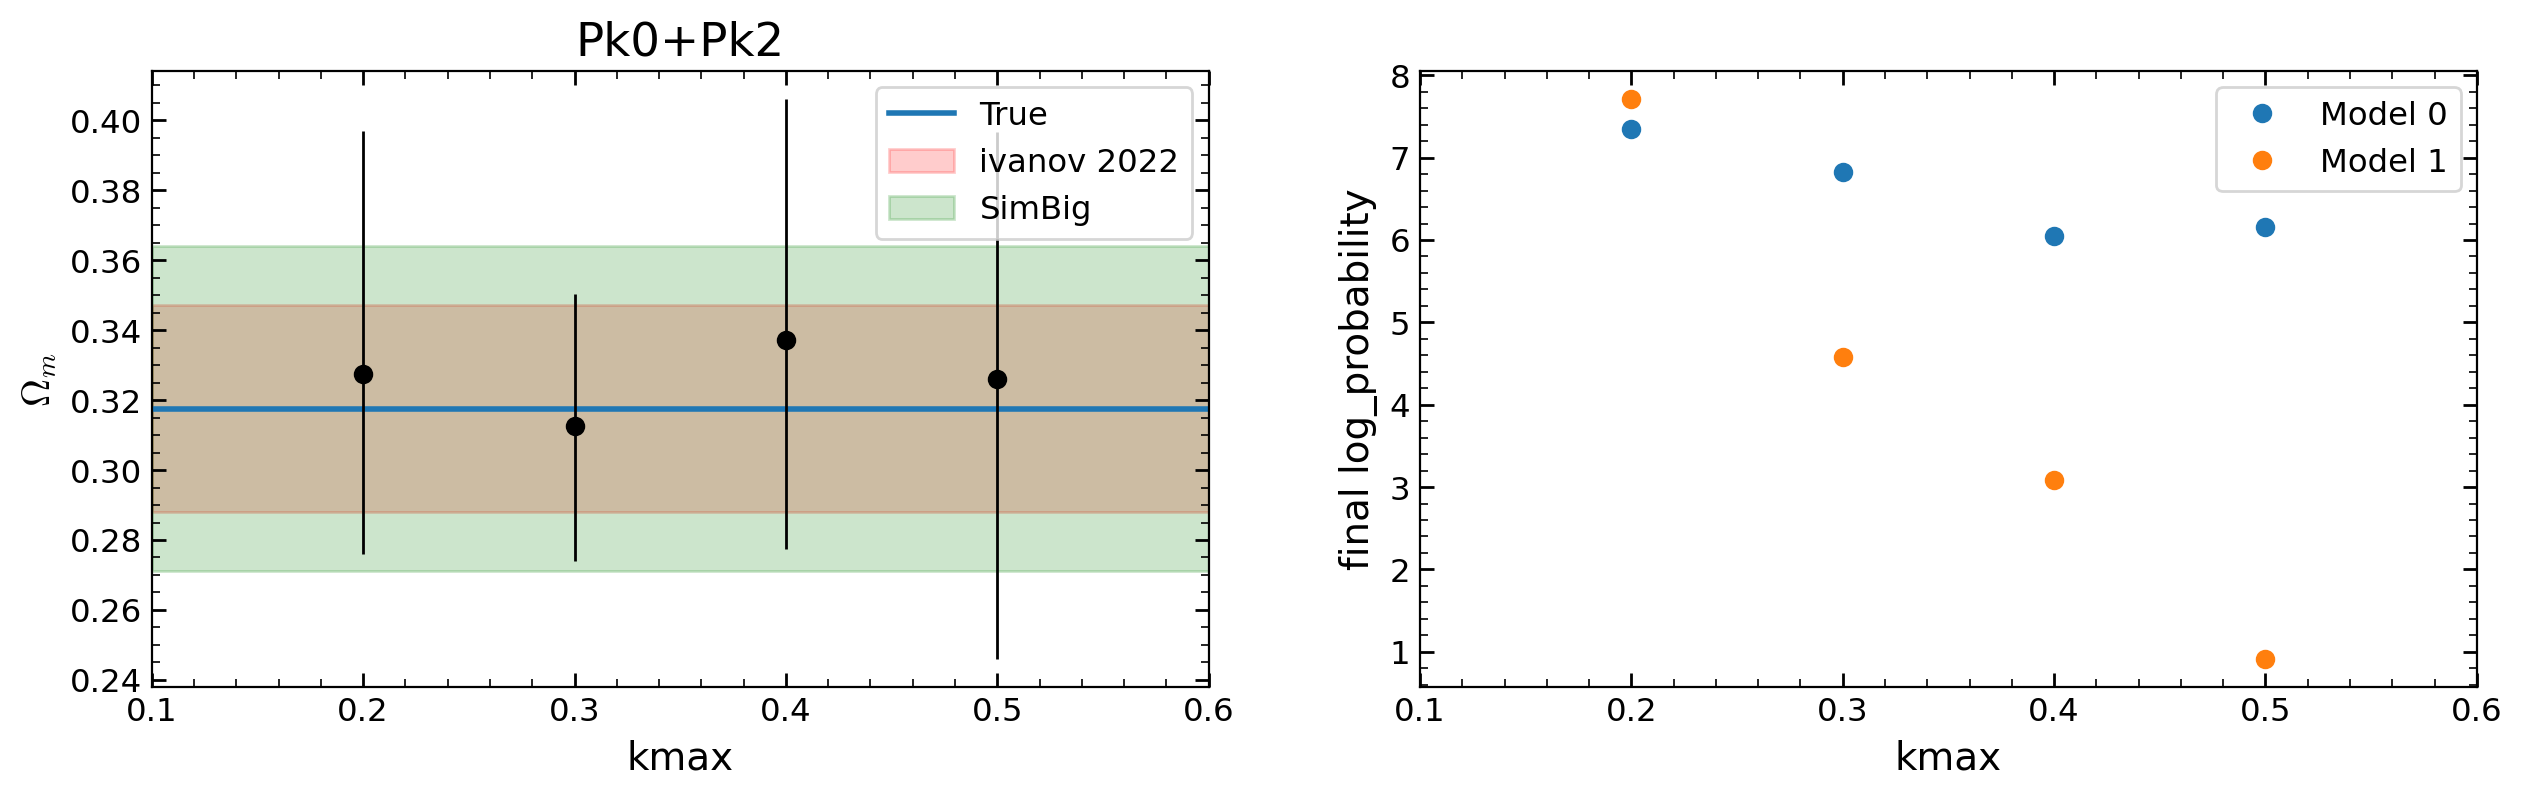

In [99]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [454, 546] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.2
(190,)


Drawing 454 posterior samples: 804it [00:00, 16848.89it/s]            
Drawing 546 posterior samples: 812it [00:00, 53452.43it/s]            
INFO:root:Sampling models with [574, 426] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.3
(284,)


Drawing 574 posterior samples: 1057it [00:00, 21057.28it/s]           
Drawing 426 posterior samples: 742it [00:00, 48377.51it/s]            
INFO:root:Sampling models with [595, 405] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.4
(380,)


Drawing 595 posterior samples: 1080it [00:00, 20798.77it/s]           
Drawing 405 posterior samples: 639it [00:00, 41265.61it/s]            
INFO:root:Sampling models with [572, 428] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.5
(476,)


Drawing 572 posterior samples: 881it [00:00, 16950.14it/s]            
Drawing 428 posterior samples: 674it [00:00, 38542.81it/s]            


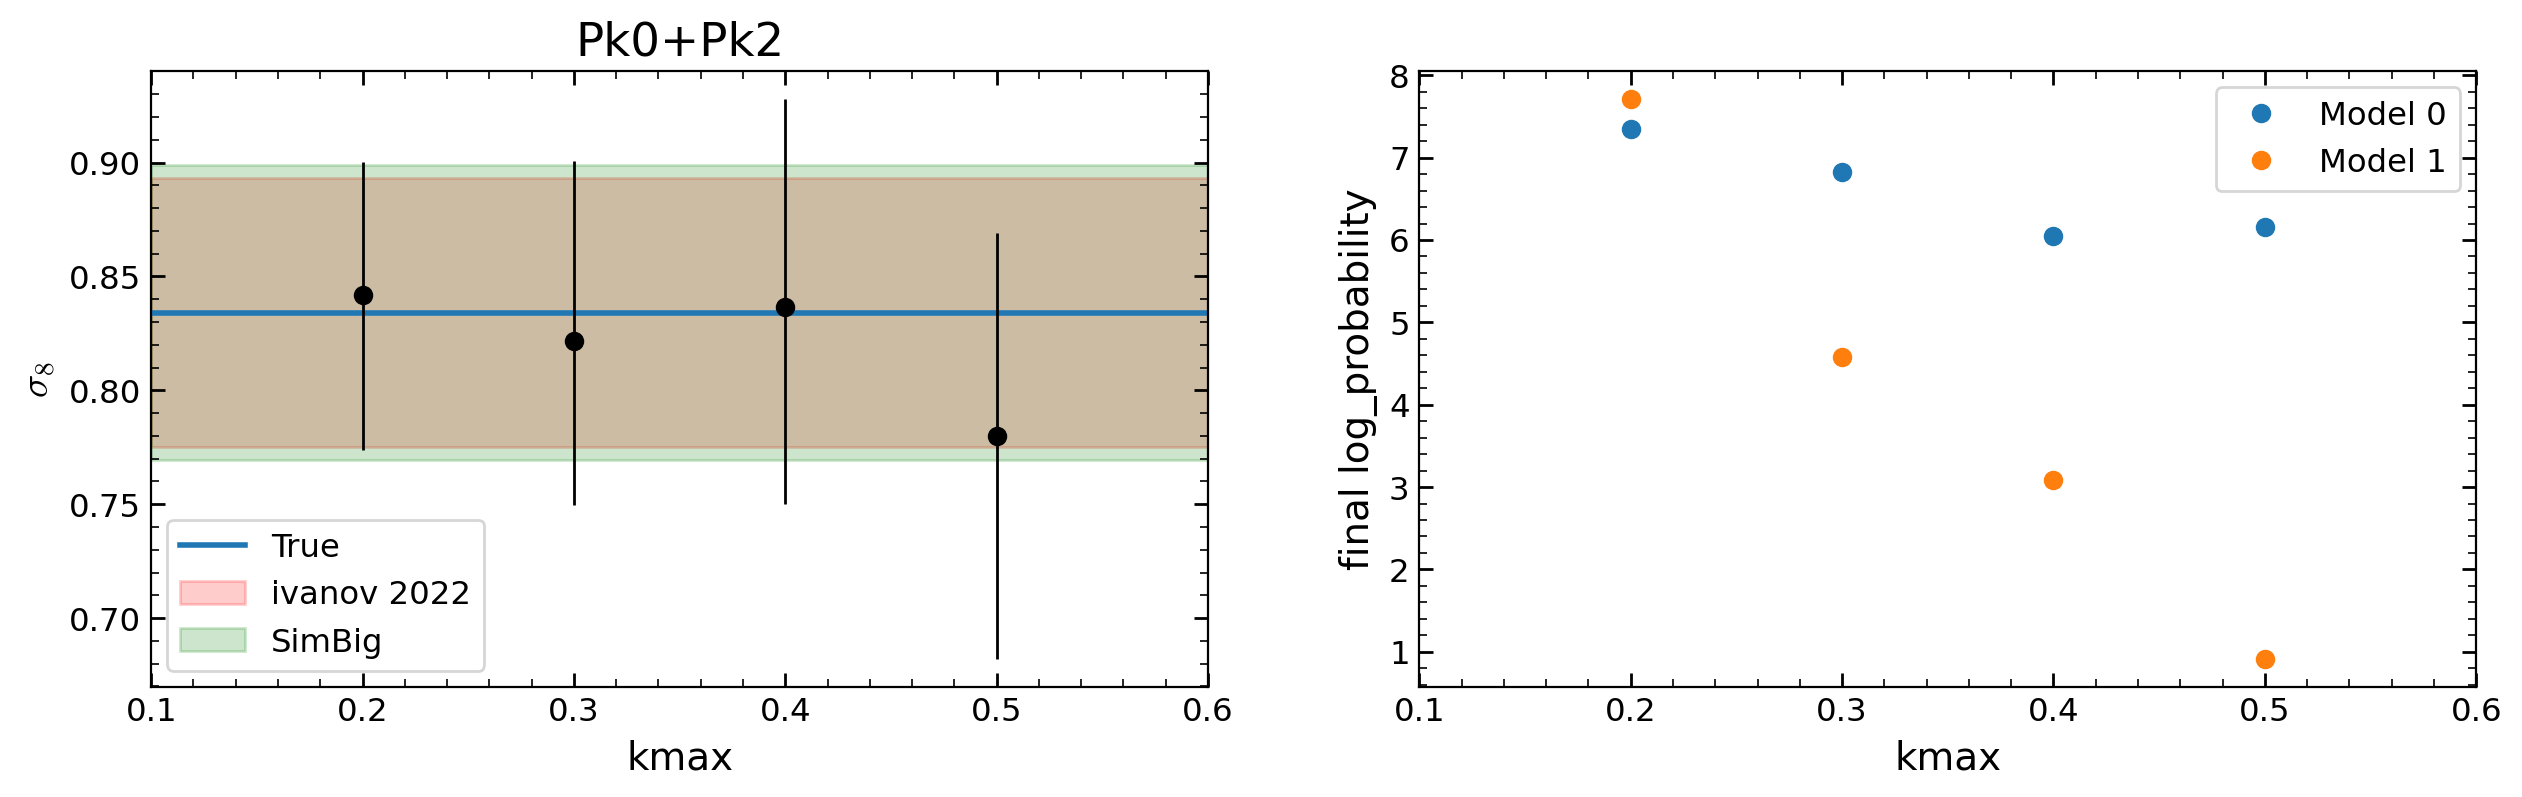

In [100]:
# sigma_8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [853, 147] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.2
(220,)


Drawing 853 posterior samples: 1448it [00:00, 9827.72it/s]            
Drawing 147 posterior samples: 178it [00:00, 7498.63it/s]             
INFO:root:Sampling models with [812, 188] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.3
(332,)


Drawing 812 posterior samples: 1433it [00:00, 9898.45it/s]            
Drawing 188 posterior samples: 210it [00:00, 8101.43it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4


INFO:root:Sampling models with [895, 105] samples each.


(444,)


Drawing 895 posterior samples: 1699it [00:00, 10981.85it/s]           
Drawing 105 posterior samples: 145it [00:00, 4002.70it/s]             

/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.5



INFO:root:Sampling models with [953, 47] samples each.


(556,)


Drawing 953 posterior samples: 1811it [00:00, 11282.25it/s]           
Drawing 47 posterior samples: 66it [00:00, 1959.61it/s]             


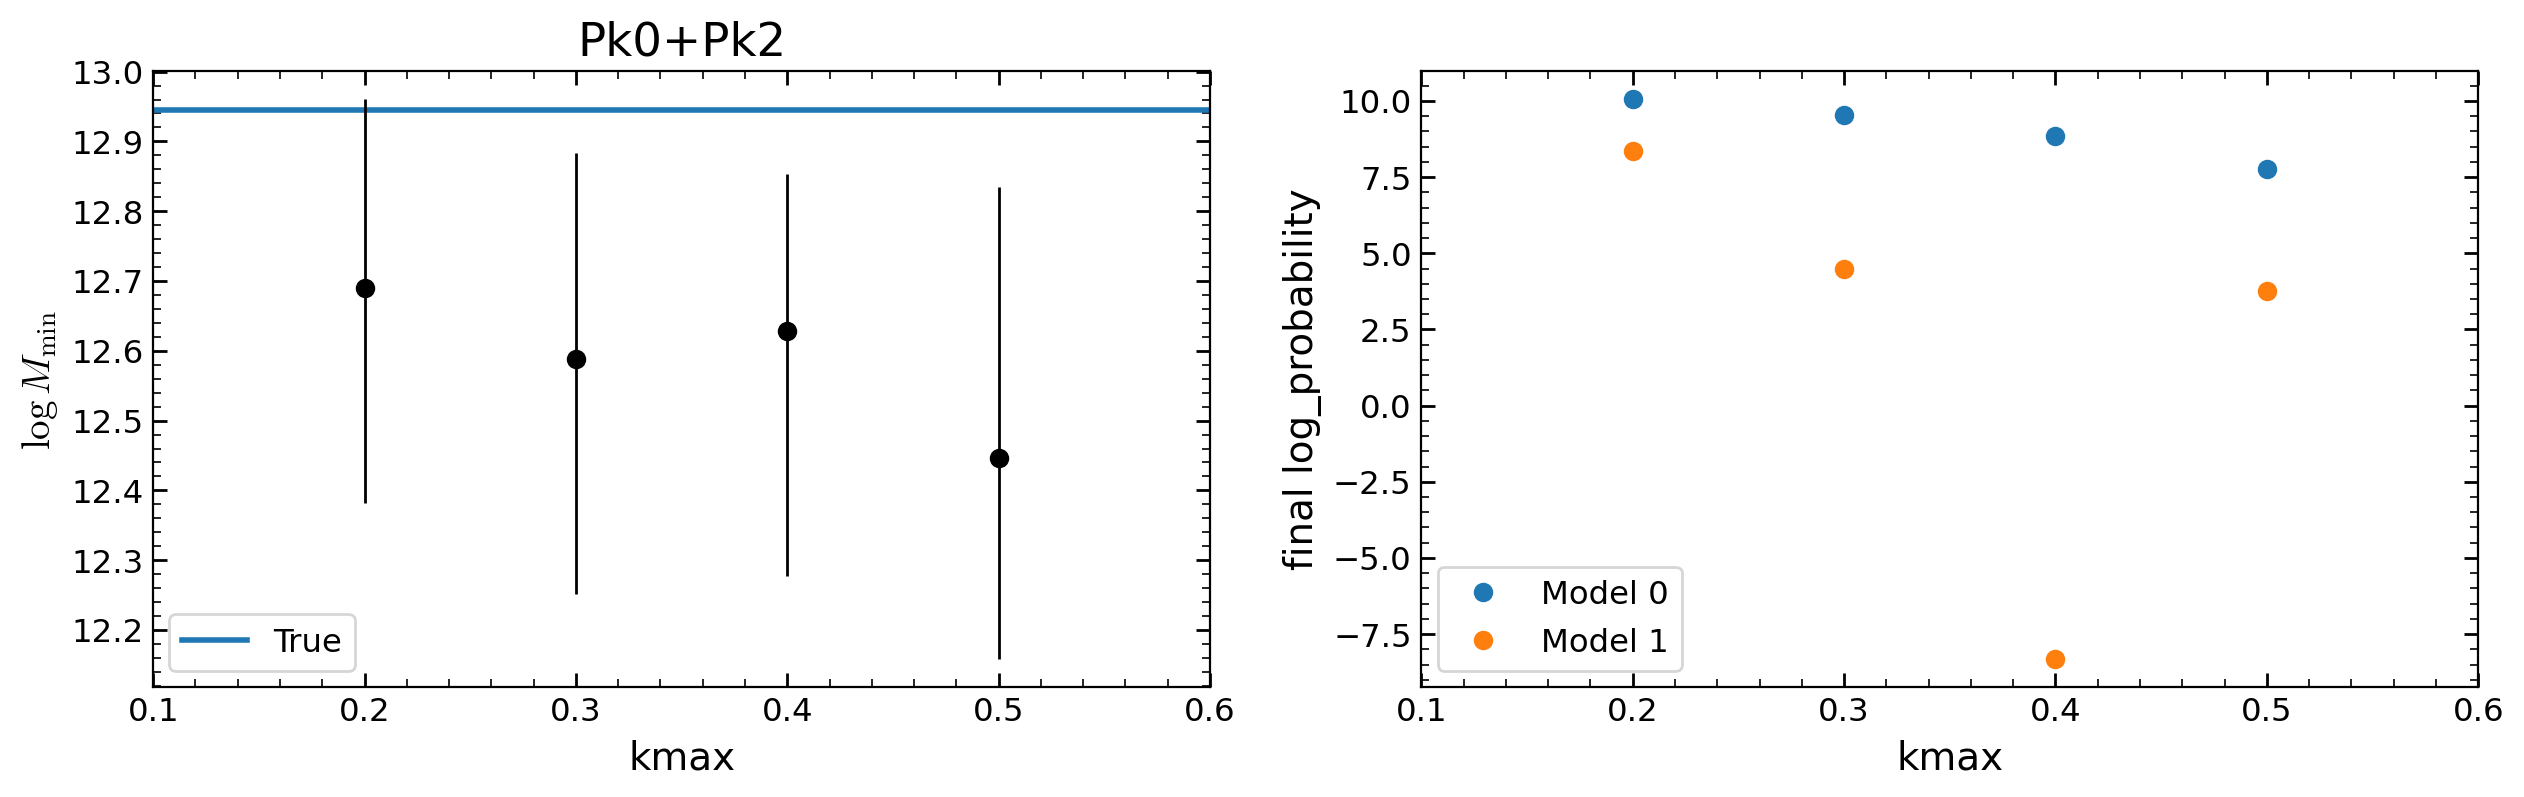

In [67]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

NameError: name 'trueparams' is not defined

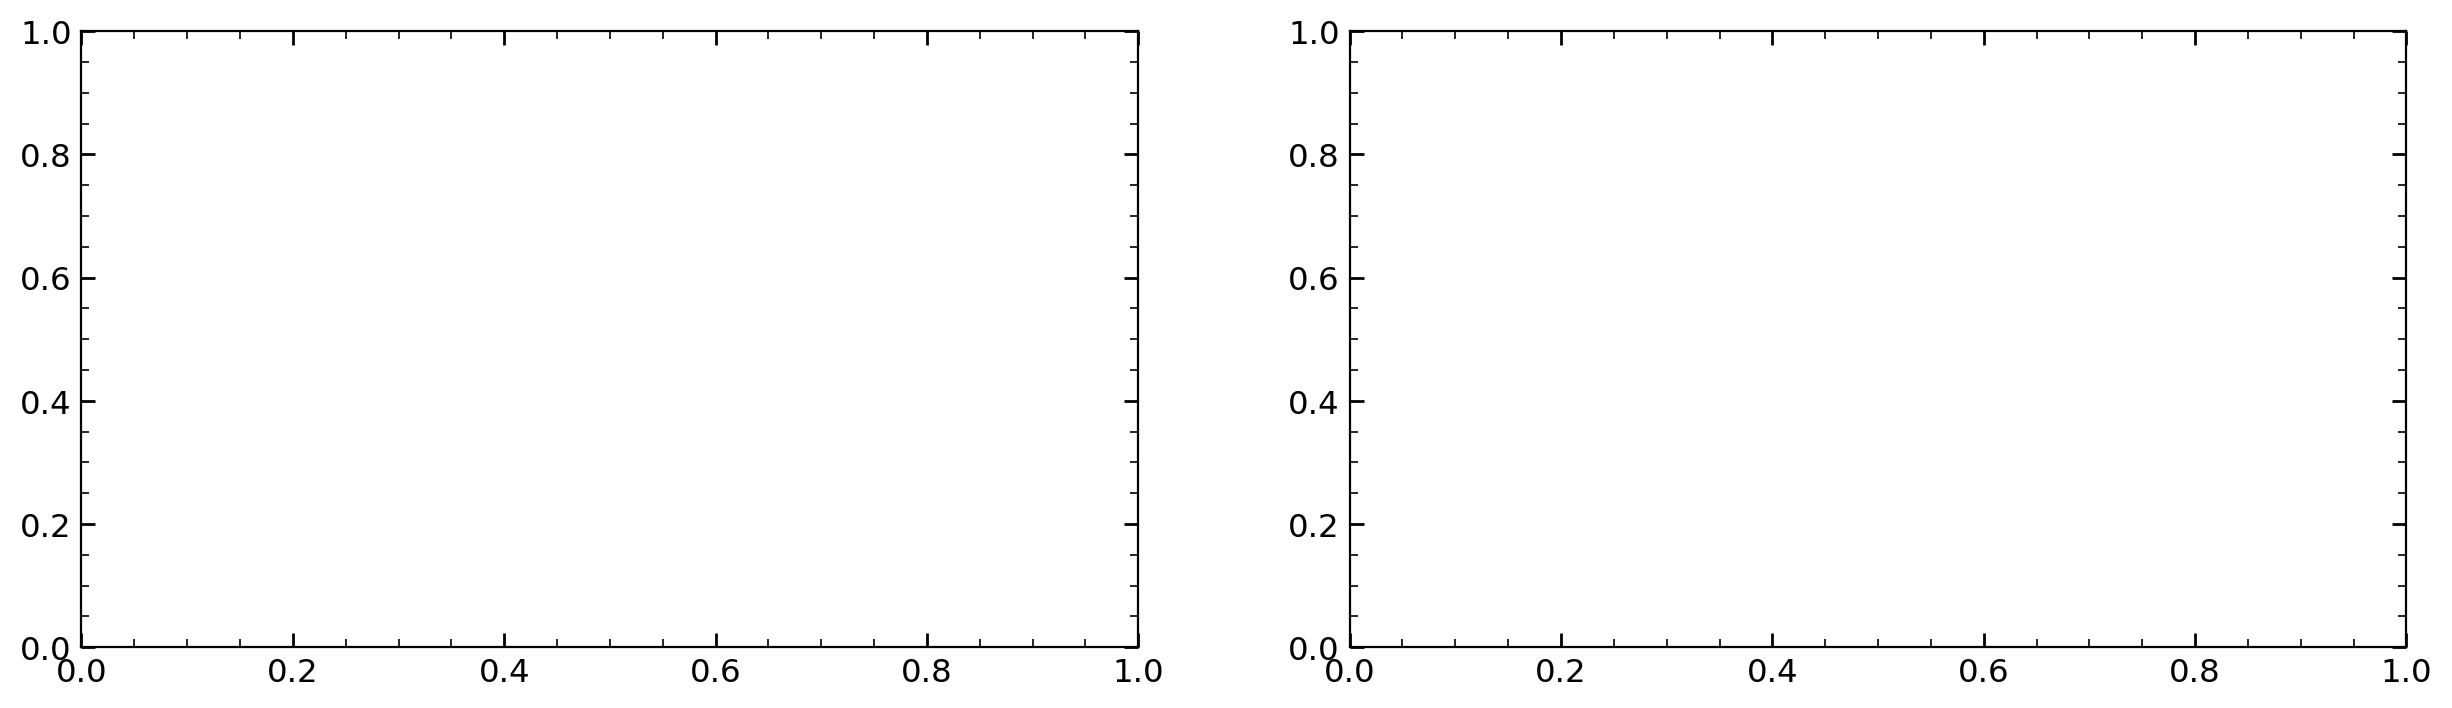

In [ ]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Qk0']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1372it [00:00, 8680.19it/s]            
Drawing 126 posterior samples: 128it [00:00, 3677.93it/s]             
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1714it [00:00, 10559.12it/s]           
Drawing 105 posterior samples: 136it [00:00, 3783.69it/s]             
INFO:root:Sampling models with [1000, 0] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 1000 posterior samples: 1674it [00:00, 9345.91it/s]             


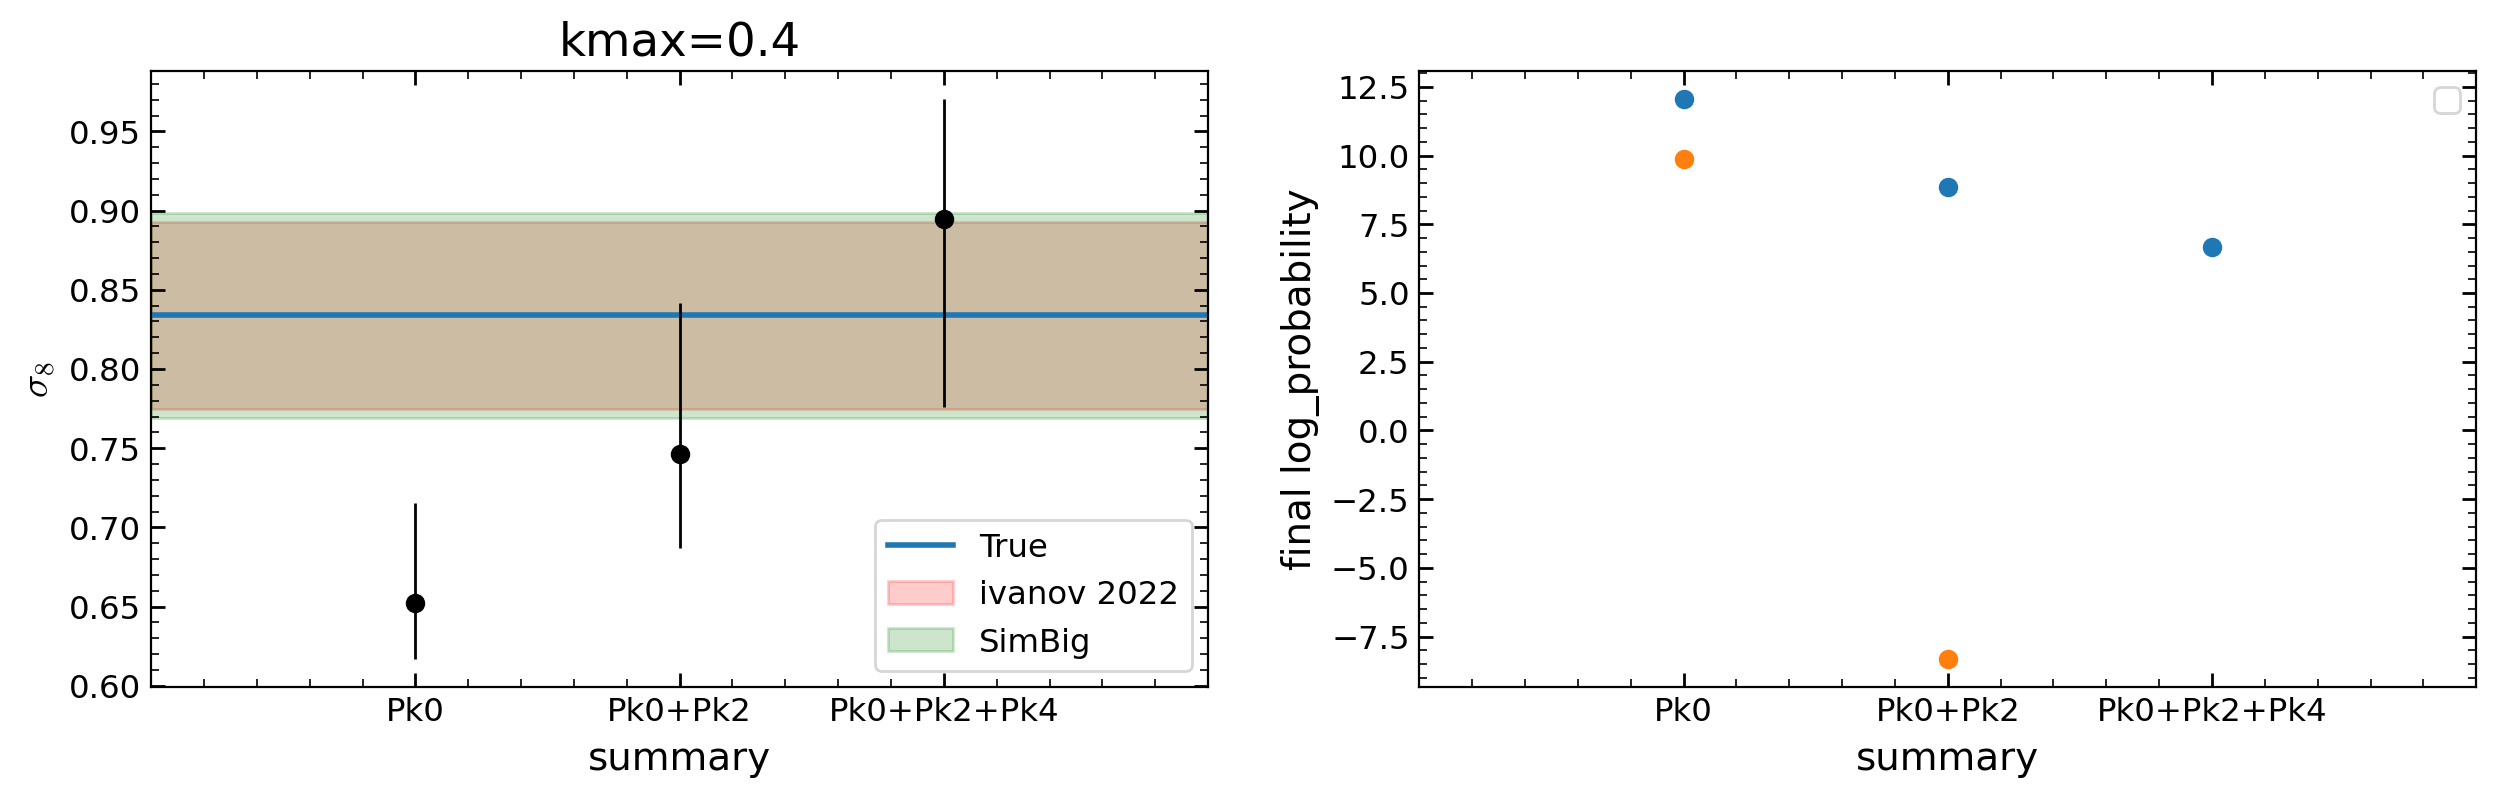

In [77]:
# sigma8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1362it [00:00, 9113.50it/s]            
Drawing 126 posterior samples:  89%|████████▉ | 112/126 [00:00<00:00, 3231.34it/s]
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1707it [00:00, 10855.35it/s]           
Drawing 105 posterior samples: 110it [00:00, 4678.44it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4


INFO:root:Sampling models with [1000, 0] samples each.


(666,)


Drawing 1000 posterior samples: 1709it [00:00, 9988.34it/s]             


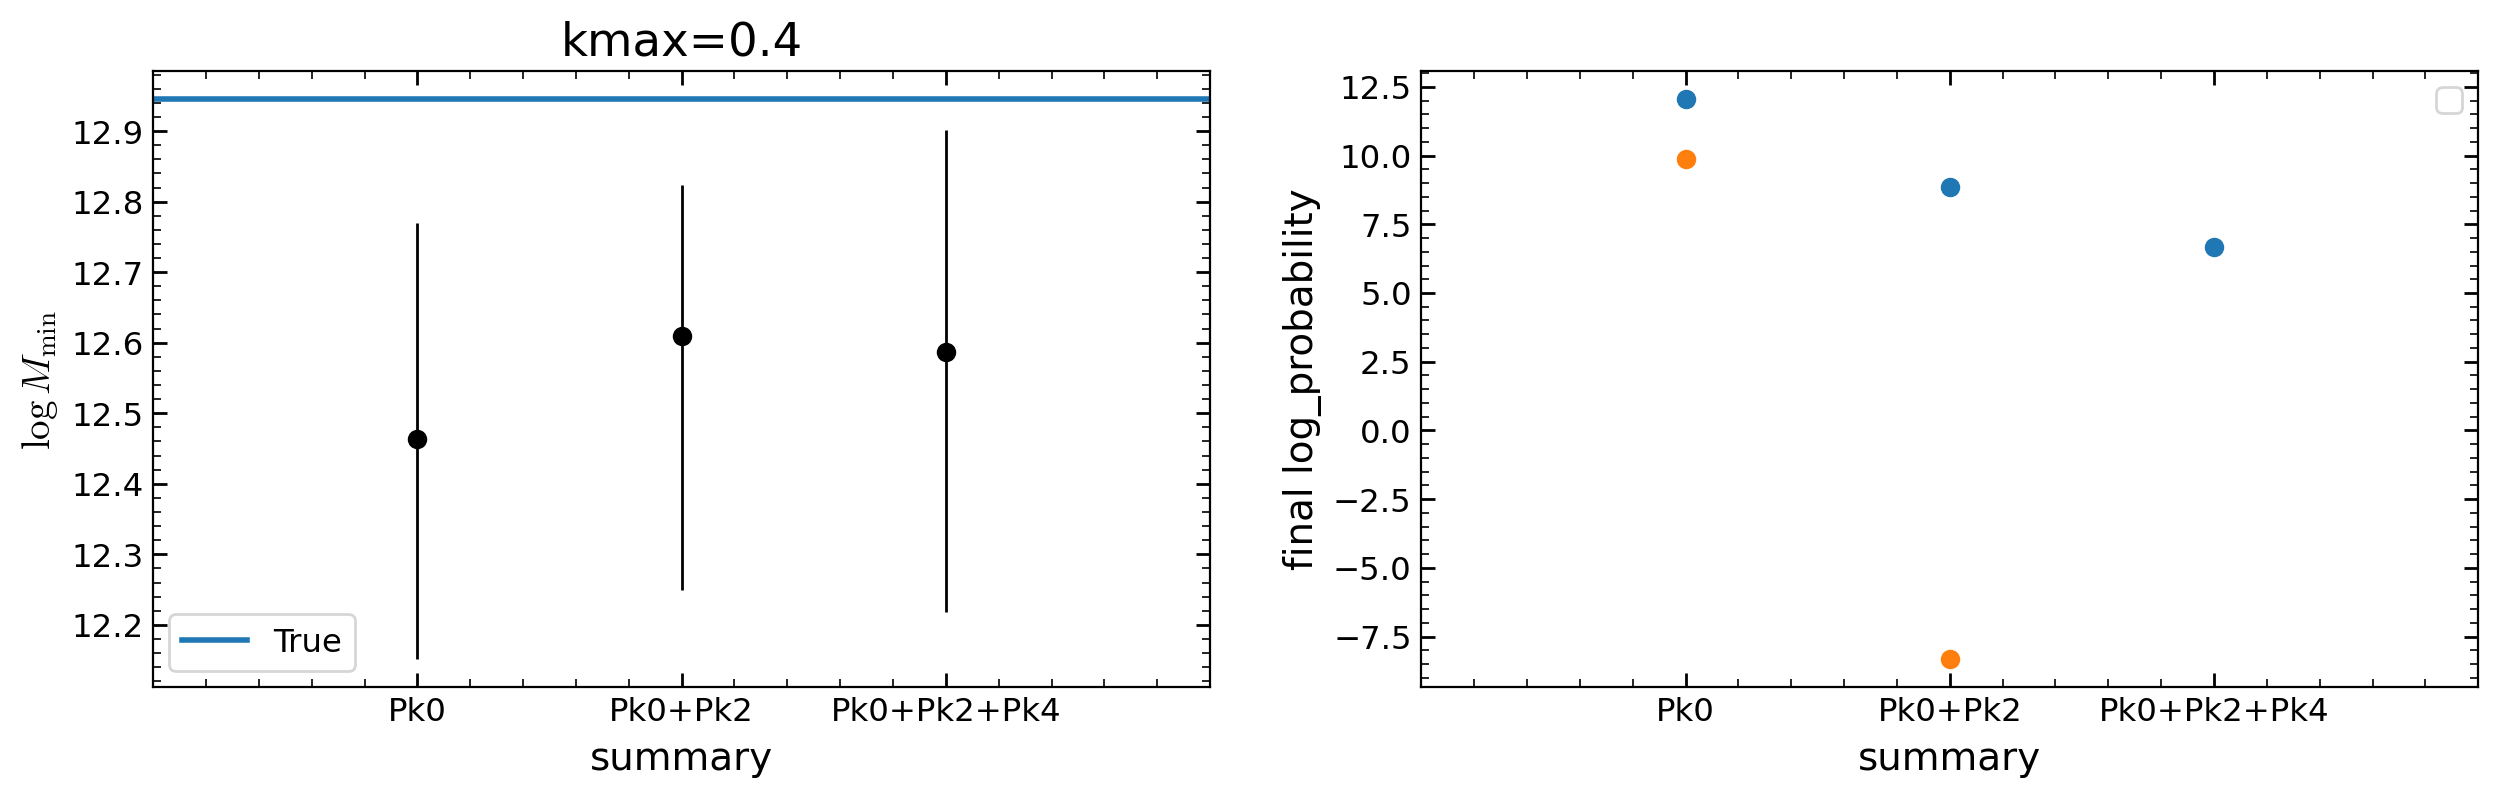

In [80]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

## Measure constraining power

## Scratch